# **Tree decision**

## **1. Importaci√≥n de librer√≠as y carga del dataset**

#### **1.1. Importaci√≥n de librer√≠as**

In [3]:
# An√°lisis de datos
import pandas as pd
import numpy as np

# Visualizaci√≥n de datos
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas de sticky-learn para modelado
from sklearn.model_selection import train_test_split, GridSearchCV, KFold  # Para divisi√≥n de datos y validaci√≥n
from sklearn.linear_model import Ridge                
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer  # Para preprocesamiento
from sklearn.compose import ColumnTransformer          # Para aplicar transformaciones a columnas espec√≠ficas
from sklearn.pipeline import Pipeline                  # Para encadenar pasos de preprocesamiento y modelado
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error  # M√©tricas de evaluaci√≥n

# Otras utilidades
import math
import warnings
warnings.filterwarnings("ignore") # Ignorar advertencias

# Configuraci√≥n para visualizaciones
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette('viridis')

# Actualizar importaciones para incluir √°rboles de decisi√≥n y validaci√≥n
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
import joblib  # Para guardar los modelos entrenados
from scipy import stats  # Para estad√≠sticas adicionales
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from scipy.special import inv_boxcox

#### **1.2. Cargar el dataset**

In [4]:
df = pd.read_csv('../data/train_es_clean.csv')

# Mostramos informaci√≥n b√°sica sobre el dataset
print(f"Dimensiones del dataset: {df.shape}")
print(f"N√∫mero de filas: {df.shape[0]}")
print(f"N√∫mero de columnas: {df.shape[1]}")

# Visualizamos primeras filas
print("\nVisualizaci√≥n de las primeras filas:")
display(df.head())

Dimensiones del dataset: (1460, 81)
N√∫mero de filas: 1460
N√∫mero de columnas: 81

Visualizaci√≥n de las primeras filas:


Id  TipoDeClaseMS Zonificaci√≥nMS  FrenteLote  √ÅreaLote Calle Callej√≥n  \
0   1             60             RL        65.0      8450  Pave  NoTiene   
1   2             20             RL        80.0      9600  Pave  NoTiene   
2   3             60             RL        68.0     11250  Pave  NoTiene   
3   4             70             RL        60.0      9550  Pave  NoTiene   
4   5             60             RL        84.0     14260  Pave  NoTiene   

  FormaLote ContornoTerreno Servicios  ... √ÅreaPiscina CalidadPiscina  \
0       Reg             Lvl    AllPub  ...           0        NoTiene   
1       Reg             Lvl    AllPub  ...           0        NoTiene   
2       IR1             Lvl    AllPub  ...           0        NoTiene   
3       IR1             Lvl    AllPub  ...           0        NoTiene   
4       IR1             Lvl    AllPub  ...           0        NoTiene   

     Cerca Caracter√≠sticaExtra ValorExtra MesVenta A√±oVenta  TipoVenta  \
0  NoTiene             Ninguna          0        2     2008         WD   
1  NoTiene             Ninguna          0        5     2007         WD   
2  NoTiene             Ninguna          0        9     2008         WD   
3  NoTiene             Ninguna          0        2     2006         WD   
4  NoTiene             Ninguna          0       12     2008         WD   

   Condici√≥nVenta  PrecioVenta  
0          Normal       208500  
1          Normal       181500  
2          Normal       223500  
3         Abnorml       140000  
4          Normal       250000  

[5 rows x 81 columns]

## **2. Exploraci√≥n inicial de los datos**

In [5]:
# Seleccionamos las variables categ√≥ricas con cardinalidad moderada para comenzar
# Esto evita generar demasiadas columnas con el endcoding

vars_cat_seleccionadas = ['Vecindario', 'Zonificaci√≥nMS', 'TipoEdificio', 'EstiloCasa', 'CalidadExterior', 'TipoGaraje']

Resumen estad√≠stico de variables num√©ricas:


Id  TipoDeClaseMS   FrenteLote       √ÅreaLote  CalidadGeneral  \
count  1460.000000    1460.000000  1460.000000    1460.000000     1460.000000   
mean    730.500000      56.897260    69.863699   10516.828082        6.099315   
std     421.610009      42.300571    22.027677    9981.264932        1.382997   
min       1.000000      20.000000    21.000000    1300.000000        1.000000   
25%     365.750000      20.000000    60.000000    7553.500000        5.000000   
50%     730.500000      50.000000    69.000000    9478.500000        6.000000   
75%    1095.250000      70.000000    79.000000   11601.500000        7.000000   
max    1460.000000     190.000000   313.000000  215245.000000       10.000000   

       Condici√≥nGeneral  A√±oConstrucci√≥n  A√±oRenovaci√≥n  \
count       1460.000000      1460.000000    1460.000000   
mean           5.575342      1971.267808    1984.865753   
std            1.112799        30.202904      20.645407   
min            1.000000      1872.000000    1950.000000   
25%            5.000000      1954.000000    1967.000000   
50%            5.000000      1973.000000    1994.000000   
75%            6.000000      2000.000000    2004.000000   
max            9.000000      2010.000000    2010.000000   

       √ÅreaRevestimientoMamposter√≠a  MetrosAcabadosS√≥tano1  ...  \
count                   1460.000000            1460.000000  ...   
mean                     103.117123              41.215461  ...   
std                      180.731373              42.372881  ...   
min                        0.000000               0.000000  ...   
25%                        0.000000               0.000000  ...   
50%                        0.000000              35.628300  ...   
75%                      164.250000              66.170162  ...   
max                     1600.000000             524.344532  ...   

       MetrosDeckMadera  MetrosPorcheAbierto  MetrosPorcheCerrado  \
count       1460.000000          1460.000000          1460.000000   
mean           8.755599             4.334879             2.039603   
std           11.644350             6.155384             5.678152   
min            0.000000             0.000000             0.000000   
25%            0.000000             0.000000             0.000000   
50%            0.000000             2.322575             0.000000   
75%           15.607704             6.317404             0.000000   
max           79.617871            50.817941            51.282456   

       MetrosPorche3Estaciones  MetrosPorcheMalla  √ÅreaPiscina    ValorExtra  \
count              1460.000000        1460.000000  1460.000000   1460.000000   
mean                  0.316761           1.399208     2.758904     43.489041   
std                   2.723668           5.180031    40.177307    496.123024   
min                   0.000000           0.000000     0.000000      0.000000   
25%                   0.000000           0.000000     0.000000      0.000000   
50%                   0.000000           0.000000     0.000000      0.000000   
75%                   0.000000           0.000000     0.000000      0.000000   
max                  47.194724          44.593440   738.000000  15500.000000   

          MesVenta     A√±oVenta    PrecioVenta  
count  1460.000000  1460.000000    1460.000000  
mean      6.321918  2007.815753  180921.195890  
std       2.703626     1.328095   79442.502883  
min       1.000000  2006.000000   34900.000000  
25%       5.000000  2007.000000  129975.000000  
50%       6.000000  2008.000000  163000.000000  
75%       8.000000  2009.000000  214000.000000  
max      12.000000  2010.000000  755000.000000  

[8 rows x 38 columns]


Verificaci√≥n de valores nulos:
Series([], dtype: int64)


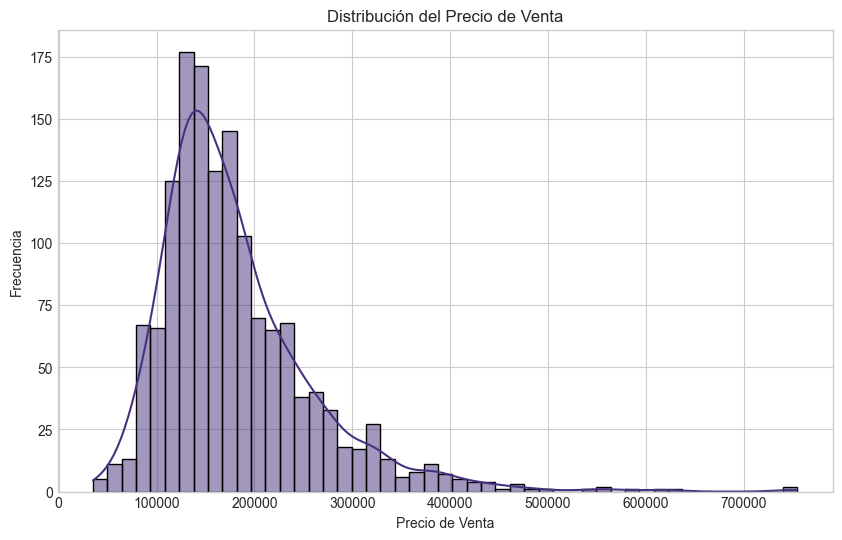

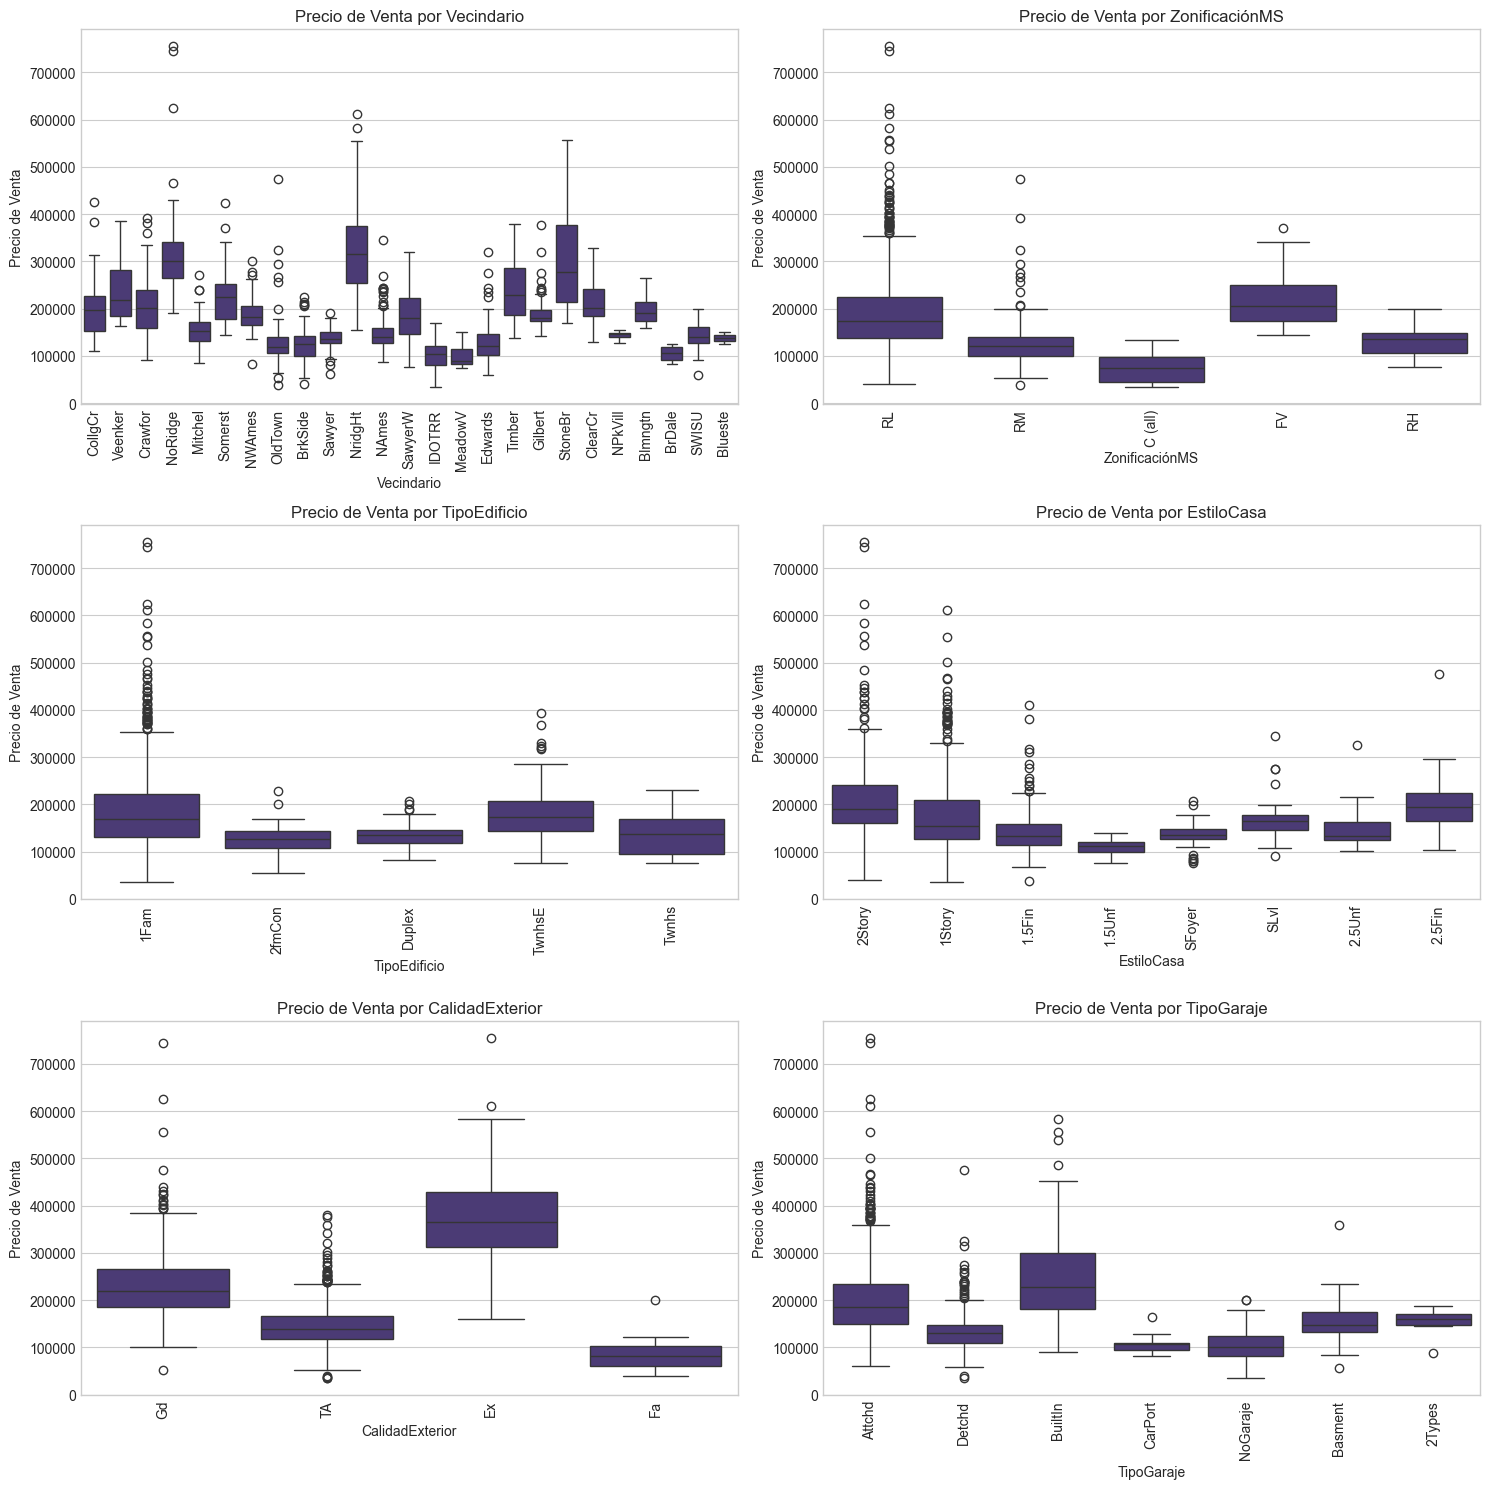

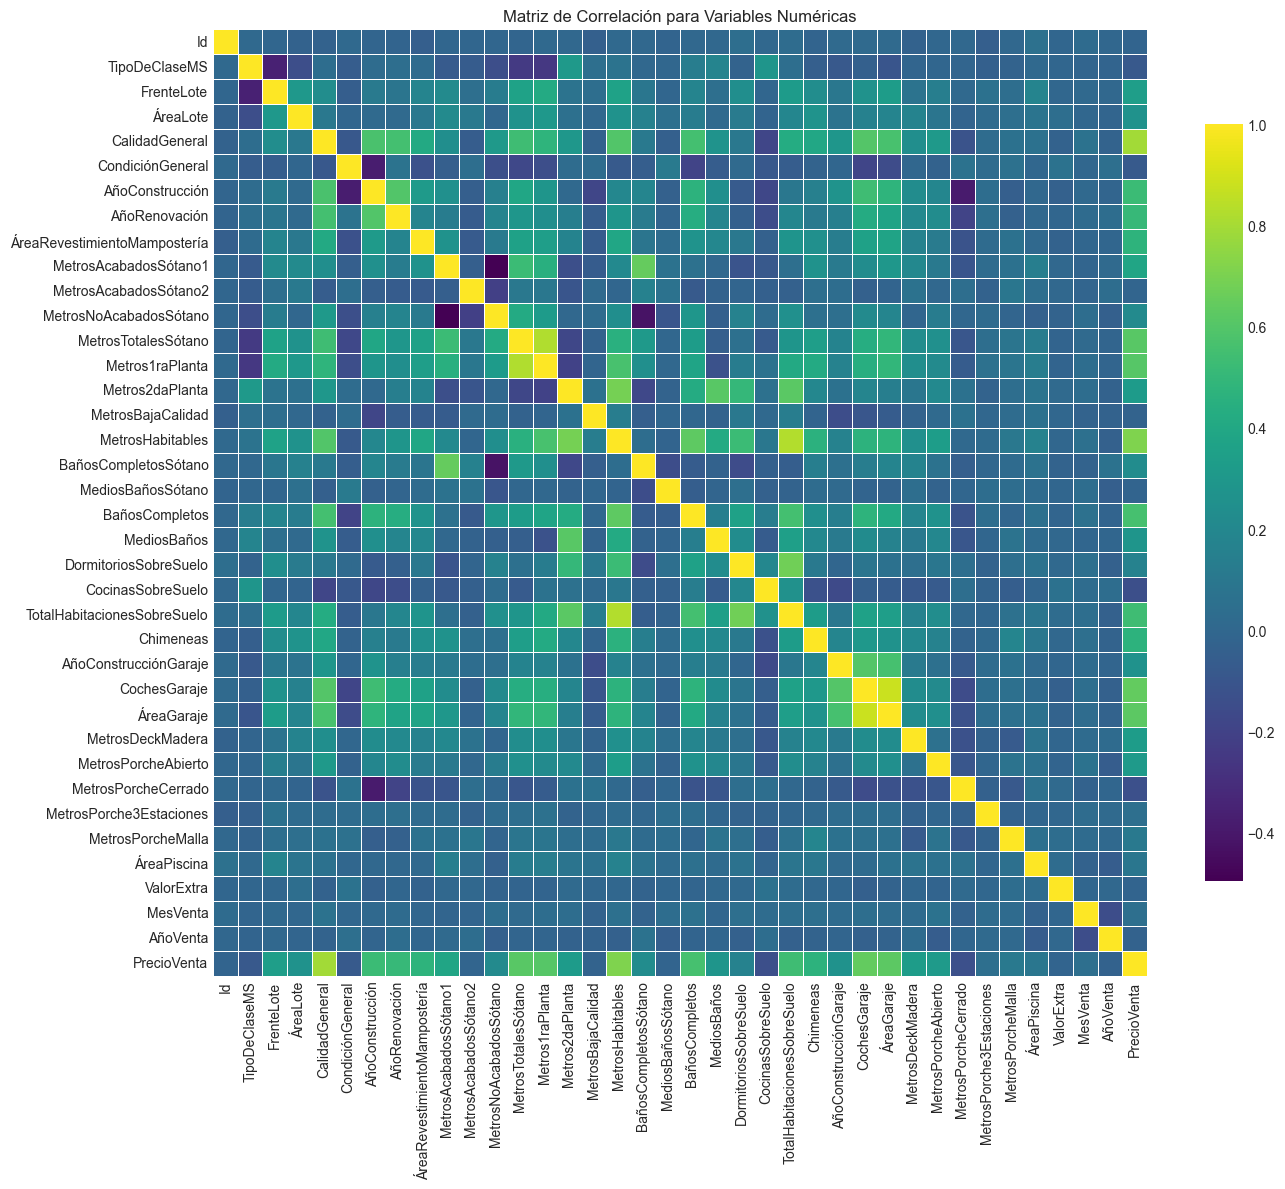


Top 10 caracter√≠sticas con mayor correlaci√≥n con el Precio de Venta:
CalidadGeneral                 0.790982
MetrosHabitables               0.708624
CochesGaraje                   0.640409
√ÅreaGaraje                     0.623431
MetrosTotalesS√≥tano            0.613581
Metros1raPlanta                0.605852
Ba√±osCompletos                 0.560664
TotalHabitacionesSobreSuelo    0.533723
A√±oConstrucci√≥n                0.522897
A√±oRenovaci√≥n                  0.507101
Name: PrecioVenta, dtype: float64


In [6]:
# Informaci√≥n estad√≠stica detallada del dataset
print("Resumen estad√≠stico de variables num√©ricas:")
display(df.describe())

# Verificar valores nulos
print("\nVerificaci√≥n de valores nulos:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

# Visualizar la distribuci√≥n de la variable objetivo (PrecioVenta)
plt.figure(figsize=(10, 6))
sns.histplot(df['PrecioVenta'], kde=True)
plt.title('Distribuci√≥n del Precio de Venta')
plt.xlabel('Precio de Venta')
plt.ylabel('Frecuencia')
plt.show()

# Visualizar la relaci√≥n entre variables categ√≥ricas seleccionadas y el precio de venta
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.flatten()

for i, var in enumerate(vars_cat_seleccionadas):
    sns.boxplot(x=var, y='PrecioVenta', data=df, ax=axes[i])
    axes[i].set_title(f'Precio de Venta por {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Precio de Venta')
    axes[i].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

# Matriz de correlaci√≥n para variables num√©ricas
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = df[numeric_columns].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=False, cmap='viridis', 
            linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Matriz de Correlaci√≥n para Variables Num√©ricas')
plt.tight_layout()
plt.show()

# Top 10 caracter√≠sticas con mayor correlaci√≥n con el precio de venta
precio_correlations = correlation_matrix['PrecioVenta'].sort_values(ascending=False)
print("\nTop 10 caracter√≠sticas con mayor correlaci√≥n con el Precio de Venta:")
print(precio_correlations[1:11])  # Excluyendo la correlaci√≥n consigo misma

## **3. Preparaci√≥n de los Datos**

N√∫mero de variables categ√≥ricas: 43
N√∫mero de variables num√©ricas: 36


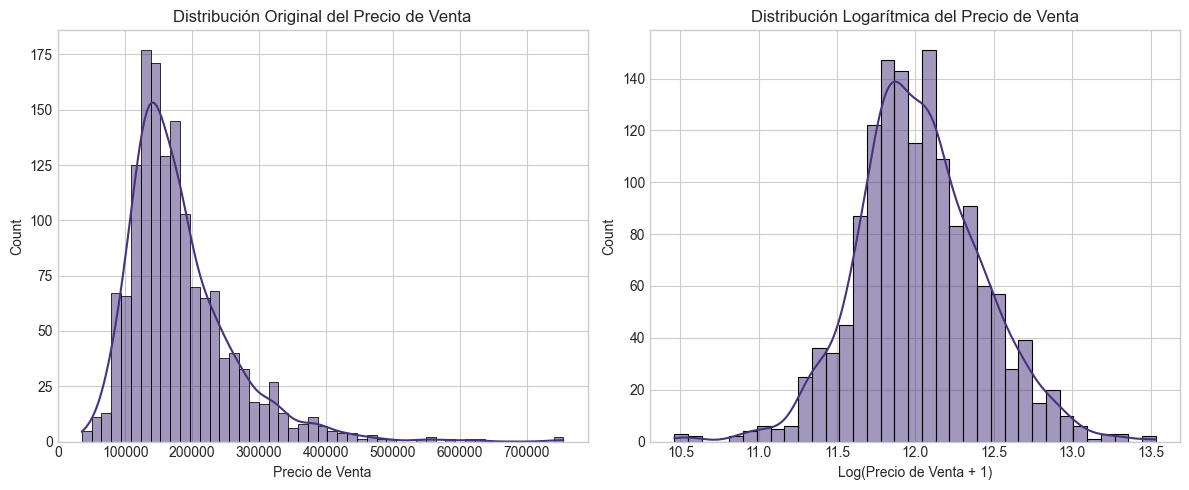

Variables num√©ricas con asimetr√≠a significativa: 22
['TipoDeClaseMS', 'FrenteLote', '√ÅreaLote', '√ÅreaRevestimientoMamposter√≠a', 'MetrosAcabadosS√≥tano1'] ...


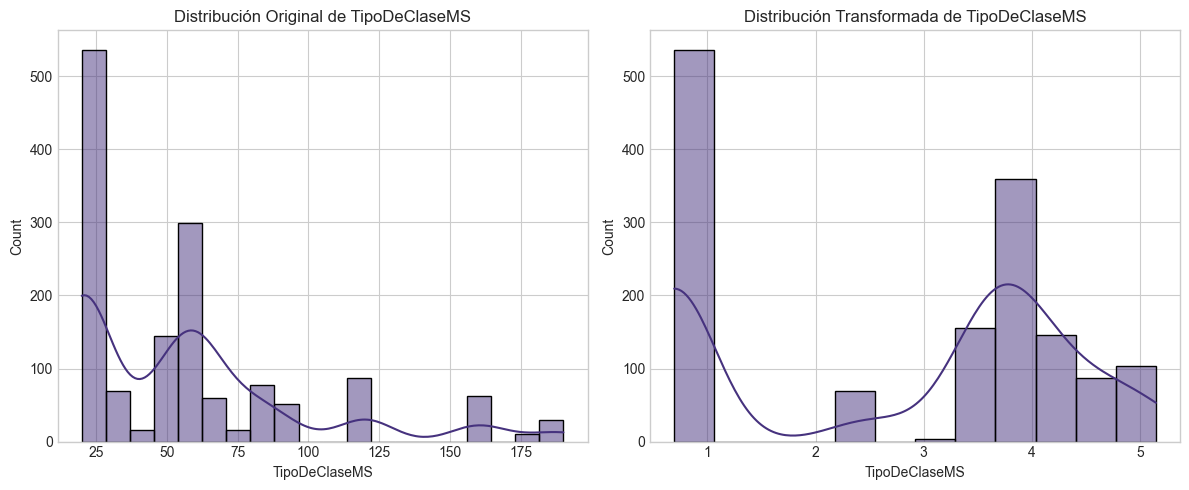

Forma de los datos de entrenamiento procesados: (1168, 90)
Forma de los datos de prueba procesados: (292, 90)


In [7]:
# Identificar variables categ√≥ricas y num√©ricas
cat_columns = df.select_dtypes(include=['object']).columns.tolist()
num_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
num_columns.remove('Id')  # Eliminar la columna Id
num_columns.remove('PrecioVenta')  # Eliminar la variable objetivo

print(f"N√∫mero de variables categ√≥ricas: {len(cat_columns)}")
print(f"N√∫mero de variables num√©ricas: {len(num_columns)}")

# Para simplificar, usaremos solo las variables categ√≥ricas seleccionadas
X_cat = df[vars_cat_seleccionadas]
X_num = df[num_columns]
y = df['PrecioVenta']

# Aplicar transformaci√≥n logar√≠tmica a la variable objetivo para manejar la asimetr√≠a de precios
# Esto ayuda a que el modelo maneje mejor la gran diferencia entre precios altos y bajos
y_log = np.log1p(y)  # log1p = log(1+x) evita problemas con valores cero

# Visualizar la distribuci√≥n antes y despu√©s de la transformaci√≥n logar√≠tmica
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(y, kde=True)
plt.title('Distribuci√≥n Original del Precio de Venta')
plt.xlabel('Precio de Venta')

plt.subplot(1, 2, 2)
sns.histplot(y_log, kde=True)
plt.title('Distribuci√≥n Logar√≠tmica del Precio de Venta')
plt.xlabel('Log(Precio de Venta + 1)')

plt.tight_layout()
plt.show()

# Identificar variables num√©ricas con distribuci√≥n sesgada que podr√≠an beneficiarse de transformaci√≥n logar√≠tmica
skewed_features = []
for feature in num_columns:
    # Calcular la asimetr√≠a (skewness)
    skewness = X_num[feature].skew()
    if abs(skewness) > 0.75:  # Umbral com√∫n para determinar si hay asimetr√≠a significativa
        skewed_features.append(feature)
        
print(f"Variables num√©ricas con asimetr√≠a significativa: {len(skewed_features)}")
print(skewed_features[:5], "..." if len(skewed_features) > 5 else "")

# Aplicar transformaci√≥n logar√≠tmica a caracter√≠sticas num√©ricas sesgadas
X_num_transformed = X_num.copy()
for feature in skewed_features:
    # Aplicamos log1p para manejar valores cero y negativos
    X_num_transformed[feature] = np.log1p(X_num[feature] - X_num[feature].min() + 1)

# Comparar distribuci√≥n antes y despu√©s para una caracter√≠stica sesgada de ejemplo
if skewed_features:
    sample_feature = skewed_features[0]
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    sns.histplot(X_num[sample_feature], kde=True)
    plt.title(f'Distribuci√≥n Original de {sample_feature}')
    
    plt.subplot(1, 2, 2)
    sns.histplot(X_num_transformed[sample_feature], kde=True)
    plt.title(f'Distribuci√≥n Transformada de {sample_feature}')
    
    plt.tight_layout()
    plt.show()

# Manejo de outliers
def remove_outliers(df, column, threshold=3):
    z_scores = np.abs(stats.zscore(df[column].dropna()))
    outliers = np.where(z_scores > threshold)[0]
    return df.drop(df.index[outliers])

# Aplicar a columnas num√©ricas relevantes
for col in num_columns:
    if abs(X_num[col].skew()) > 1.5:  # Columnas muy sesgadas
        X_num = remove_outliers(X_num, col)

# Ingenier√≠a de caracter√≠sticas
X_num['AreaTotal'] = X_num['MetrosTotalesS√≥tano']  # Usando el √°rea total del s√≥tano para esta caracter√≠stica
X_num['CalidadxCondicion'] = X_num['CalidadGeneral'] * X_num['Condici√≥nGeneral']
X_num['EdadCasa'] = X_num['A√±oVenta'] - X_num['A√±oConstrucci√≥n']
X_num['EdadRemodelacion'] = X_num['A√±oVenta'] - X_num['A√±oRenovaci√≥n']
# Corregido: Usamos Ba√±osCompletos en lugar de Ba√±os (que no existe en el dataset)
X_num['TotalBa√±os'] = X_num['Ba√±osCompletosS√≥tano'] + X_num['Ba√±osCompletos']

# Separar caracter√≠sticas (X) y objetivo (y)
# Creamos un transformador de columnas para aplicar diferentes preprocesadores
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), vars_cat_seleccionadas)
    ])

# Dividir datos en conjuntos de entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(
    pd.concat([X_num_transformed, X_cat], axis=1), 
    y_log,  # Usamos la versi√≥n logar√≠tmica de los precios
    test_size=0.2, 
    random_state=42
)

# Aplicar preprocesamiento
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"Forma de los datos de entrenamiento procesados: {X_train_processed.shape}")
print(f"Forma de los datos de prueba procesados: {X_test_processed.shape}")

## **4. Construcci√≥n de Modelos Simples**

### **4.1. Modelo de √Årbol de Decisi√≥n B√°sico**

In [8]:
# Inicializar y entrenar el modelo de √Årbol de Decisi√≥n
dt_model = DecisionTreeRegressor(
    max_depth=5,          # Controla la profundidad del √°rbol para evitar sobreajuste
    min_samples_split=5,  # M√≠nimo de muestras requeridas para dividir un nodo
    min_samples_leaf=2,   # M√≠nimo de muestras requeridas en un nodo hoja
    random_state=42       # Para reproducibilidad
)
dt_model.fit(X_train_processed, y_train)

# Hacer predicciones
dt_pred = dt_model.predict(X_test_processed)

# Evaluar el modelo
print("Resultados del √Årbol de Decisi√≥n Regresor:")
print(f"Error Absoluto Medio (MAE): {mean_absolute_error(y_test, dt_pred):.2f}")
print(f"Error Cuadr√°tico Medio (MSE): {mean_squared_error(y_test, dt_pred):.2f}")
print(f"Ra√≠z del Error Cuadr√°tico Medio (RMSE): {math.sqrt(mean_squared_error(y_test, dt_pred)):.2f}")
print(f"Puntuaci√≥n R¬≤: {r2_score(y_test, dt_pred):.4f}")

Resultados del √Årbol de Decisi√≥n Regresor:
Error Absoluto Medio (MAE): 0.15
Error Cuadr√°tico Medio (MSE): 0.04
Ra√≠z del Error Cuadr√°tico Medio (RMSE): 0.21
Puntuaci√≥n R¬≤: 0.7652


### **4.2. Visualizaci√≥n del √Årbol de Decisi√≥n**

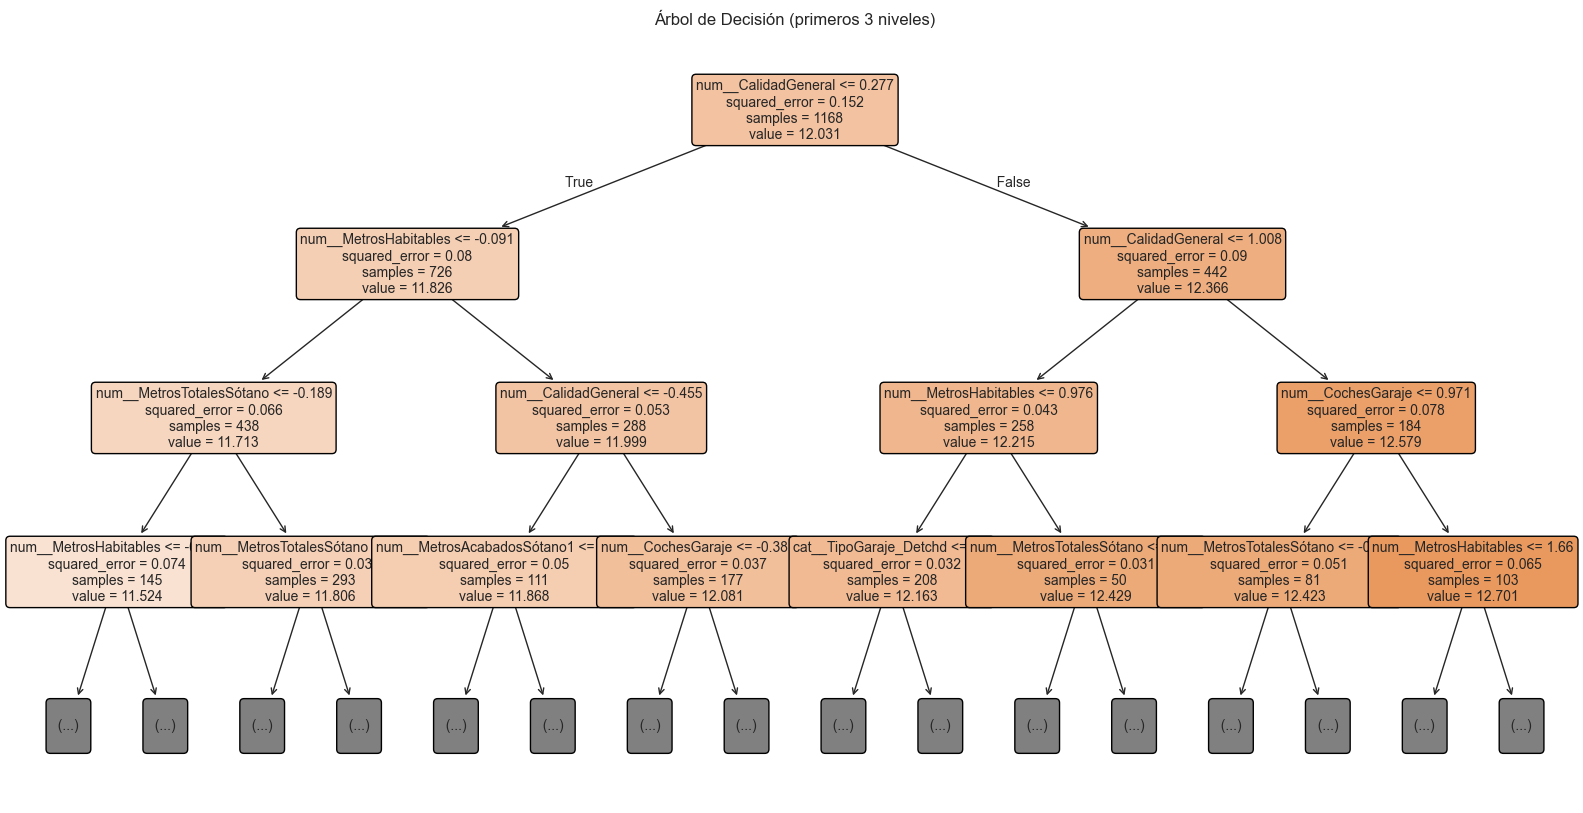

In [9]:
# Visualizar el √°rbol (simplificado para mejor visualizaci√≥n)
plt.figure(figsize=(20, 10))
plot_tree(dt_model, max_depth=3, feature_names=list(preprocessor.get_feature_names_out()), 
          filled=True, rounded=True, fontsize=10)
plt.title('√Årbol de Decisi√≥n (primeros 3 niveles)')
plt.show()

### **4.3. An√°lisis de Importancia de Caracter√≠sticas**

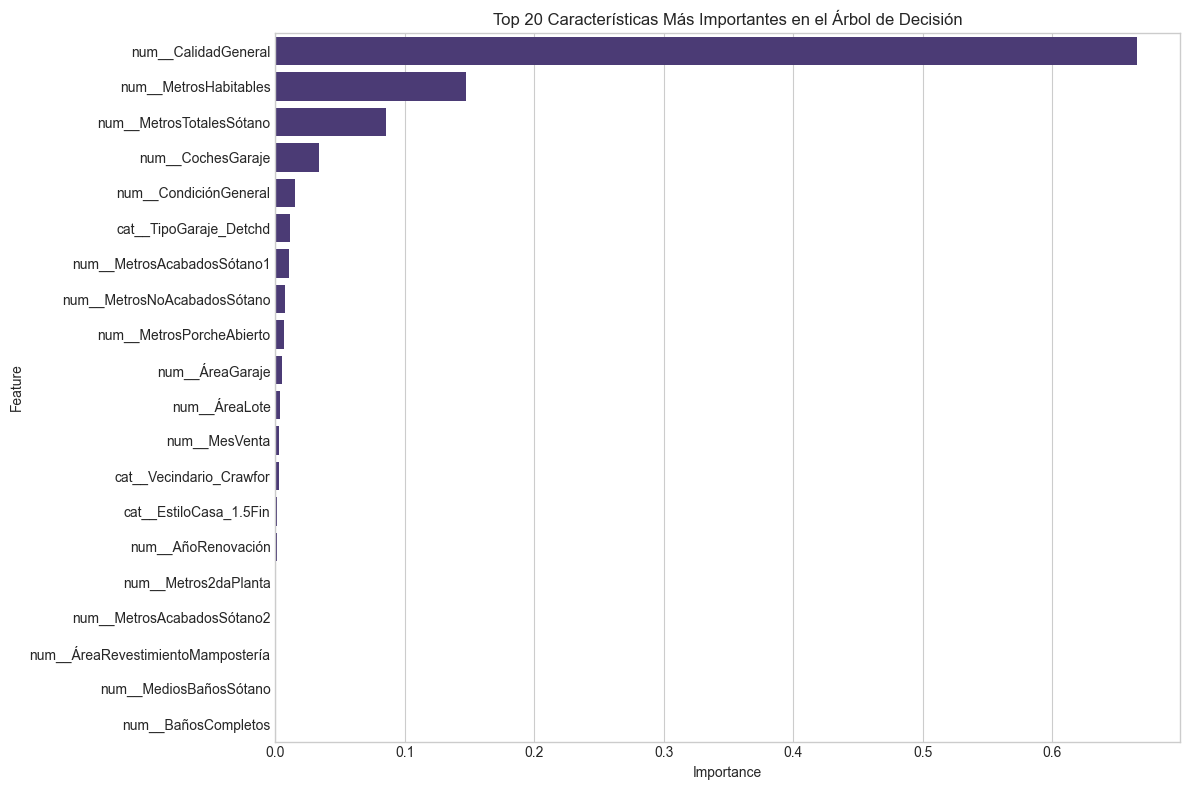

In [10]:
# Analizar la importancia de las caracter√≠sticas
feature_names = preprocessor.get_feature_names_out()
feature_importances = dt_model.feature_importances_

# Crear un DataFrame para mejor visualizaci√≥n
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Mostrar las 20 caracter√≠sticas m√°s importantes
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title('Top 20 Caracter√≠sticas M√°s Importantes en el √Årbol de Decisi√≥n')
plt.tight_layout()
plt.show()

### **4.4. Visualizar Predicciones del Modelo vs Valores Reales**

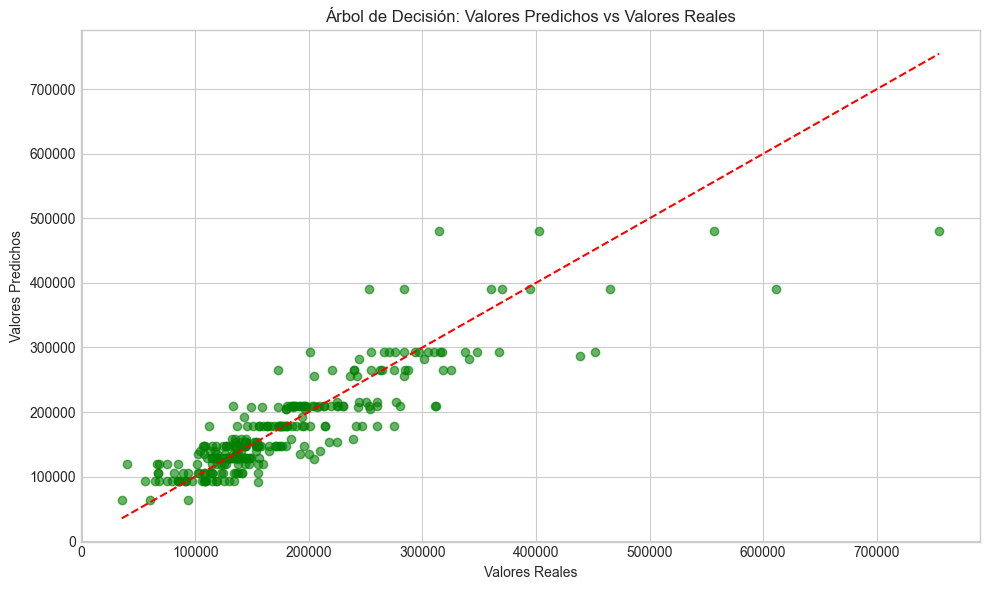

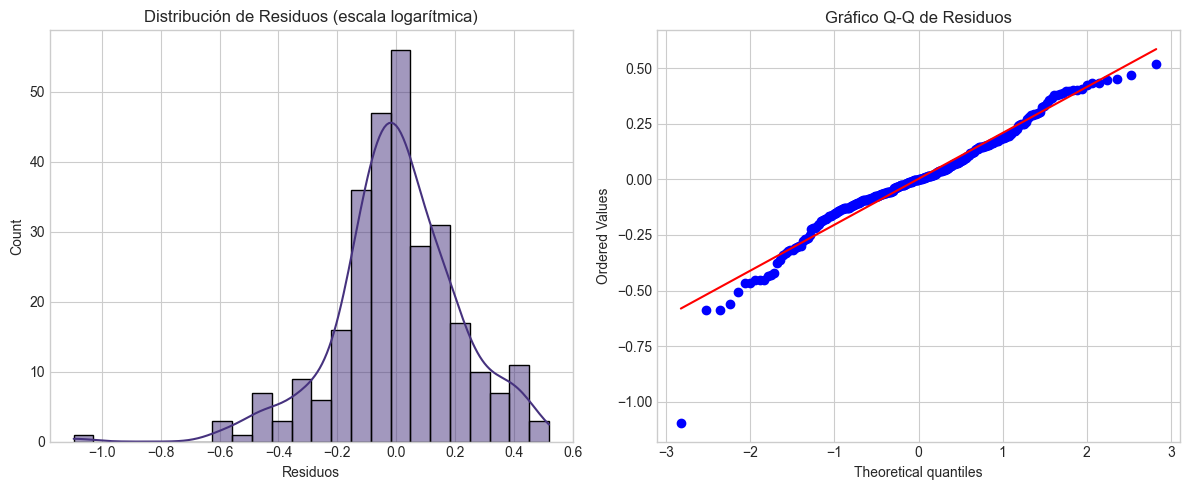

In [11]:
# Visualizaci√≥n de predicciones vs valores reales
# Para mostrar adecuadamente, convertimos las predicciones de escala logar√≠tmica a normal
y_test_original = np.expm1(y_test)  # Revertir a escala original para comparaci√≥n
dt_pred_original = np.expm1(dt_pred)

plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, dt_pred_original, color='green', alpha=0.6)
plt.plot([min(y_test_original), max(y_test_original)], [min(y_test_original), max(y_test_original)], color='red', linestyle='--')
plt.title('√Årbol de Decisi√≥n: Valores Predichos vs Valores Reales')
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.grid(True)
plt.tight_layout()
plt.show()

# An√°lisis de residuos (en escala logar√≠tmica)
residuals = y_test - dt_pred

plt.figure(figsize=(12, 5))

# Histograma de residuos
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True)
plt.title('Distribuci√≥n de Residuos (escala logar√≠tmica)')
plt.xlabel('Residuos')

# Gr√°fico Q-Q para verificar normalidad de residuos
plt.subplot(1, 2, 2)
stats.probplot(residuals, plot=plt)
plt.title('Gr√°fico Q-Q de Residuos')

plt.tight_layout()
plt.show()

## **5. Ajuste de Hiperpar√°metros**

### **5.1. Ajuste con RandomizedSearchCV**

In [12]:
# Definir la cuadr√≠cula de par√°metros para √Årbol de Decisi√≥n
dt_param_grid_extended = {
    'max_depth': [3, 4, 5, 6, 7, 8, 10, 12, 15, 20, None],
    'min_samples_split': [2, 3, 4, 5, 7, 10, 15, 20],
    'min_samples_leaf': [1, 2, 3, 4, 5, 8, 10],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'ccp_alpha': [0.0, 0.001, 0.01, 0.02, 0.05, 0.1]  # Pruning parameter
}

# Crear objeto RandomizedSearchCV
# Usamos RandomizedSearchCV cuando tenemos muchos par√°metros para probar
dt_random_search = RandomizedSearchCV(
    DecisionTreeRegressor(random_state=42),  # El modelo a ajustar
    param_distributions=dt_param_grid_extended,       # Cuadr√≠cula de par√°metros a buscar
    n_iter=50,                               # N√∫mero de combinaciones de par√°metros a probar
    cv=5,                                    # Validaci√≥n cruzada de 5 pliegues
    scoring='neg_mean_absolute_error',       # M√©trica a optimizar
    random_state=42,                         # Para reproducibilidad
    n_jobs=-1                                # Usar todos los n√∫cleos disponibles
)

# Realizar la b√∫squeda
dt_random_search.fit(X_train_processed, y_train)

# Obtener los mejores par√°metros y modelo
print("Mejores par√°metros para √Årbol de Decisi√≥n Regresor (RandomizedSearchCV):")
for param, value in dt_random_search.best_params_.items():
    print(f"{param}: {value}")

best_dt_random = dt_random_search.best_estimator_

# Hacer predicciones con el mejor modelo
dt_random_pred = best_dt_random.predict(X_test_processed)

# Evaluar el mejor modelo
print("\n√Årbol de Decisi√≥n Regresor (despu√©s del ajuste con RandomizedSearchCV):")
print(f"Error Absoluto Medio (MAE): {mean_absolute_error(y_test, dt_random_pred):.2f}")
print(f"Error Cuadr√°tico Medio (MSE): {mean_squared_error(y_test, dt_random_pred):.2f}")
print(f"Ra√≠z del Error Cuadr√°tico Medio (RMSE): {math.sqrt(mean_squared_error(y_test, dt_random_pred)):.2f}")
print(f"Puntuaci√≥n R¬≤: {r2_score(y_test, dt_random_pred):.4f}")

Mejores par√°metros para √Årbol de Decisi√≥n Regresor (RandomizedSearchCV):
min_samples_split: 3
min_samples_leaf: 4
max_features: None
max_depth: None
ccp_alpha: 0.0

√Årbol de Decisi√≥n Regresor (despu√©s del ajuste con RandomizedSearchCV):
Error Absoluto Medio (MAE): 0.14
Error Cuadr√°tico Medio (MSE): 0.04
Ra√≠z del Error Cuadr√°tico Medio (RMSE): 0.20
Puntuaci√≥n R¬≤: 0.7911


### **5.2. Ajuste con GridSearchCV**

In [13]:
# Usando los resultados del RandomizedSearchCV, podemos ajustar una b√∫squeda m√°s espec√≠fica
# Definimos una cuadr√≠cula m√°s acotada basada en los mejores resultados previos
best_params = dt_random_search.best_params_

# Imprimimos las claves disponibles para diagn√≥stico
print("Par√°metros disponibles en best_params:", list(best_params.keys()))

# Creamos una cuadr√≠cula m√°s espec√≠fica alrededor de los mejores valores encontrados
# Solo incluimos par√°metros que sabemos que existen en best_params
dt_grid = {
    'max_depth': [best_params['max_depth']-2 if best_params['max_depth'] and best_params['max_depth'] > 2 else 1, 
                  best_params['max_depth'], 
                  best_params['max_depth']+2 if best_params['max_depth'] else None],
    'min_samples_split': [max(best_params['min_samples_split']-1, 2), 
                          best_params['min_samples_split'], 
                          best_params['min_samples_split']+1],
    'min_samples_leaf': [max(best_params['min_samples_leaf']-1, 1), 
                         best_params['min_samples_leaf'], 
                         best_params['min_samples_leaf']+1],
    'max_features': [best_params['max_features']]
}

# A√±adir ccp_alpha si existe en best_params
if 'ccp_alpha' in best_params:
    dt_grid['ccp_alpha'] = [best_params['ccp_alpha']]

# Crear objeto GridSearchCV para una b√∫squeda exhaustiva con los par√°metros acotados
dt_grid_search = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_grid=dt_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

# Realizar la b√∫squeda
dt_grid_search.fit(X_train_processed, y_train)

# Obtener los mejores par√°metros y modelo
print("Mejores par√°metros para √Årbol de Decisi√≥n Regresor (GridSearchCV):")
for param, value in dt_grid_search.best_params_.items():
    print(f"{param}: {value}")

best_dt_grid = dt_grid_search.best_estimator_

# Hacer predicciones con el mejor modelo
dt_grid_pred = best_dt_grid.predict(X_test_processed)

# Evaluar el mejor modelo
print("\n√Årbol de Decisi√≥n Regresor (despu√©s del ajuste con GridSearchCV):")
print(f"Error Absoluto Medio (MAE): {mean_absolute_error(y_test, dt_grid_pred):.2f}")
print(f"Error Cuadr√°tico Medio (MSE): {mean_squared_error(y_test, dt_grid_pred):.2f}")
print(f"Ra√≠z del Error Cuadr√°tico Medio (RMSE): {math.sqrt(mean_squared_error(y_test, dt_grid_pred)):.2f}")
print(f"Puntuaci√≥n R¬≤: {r2_score(y_test, dt_grid_pred):.4f}")

Par√°metros disponibles en best_params: ['min_samples_split', 'min_samples_leaf', 'max_features', 'max_depth', 'ccp_alpha']
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Mejores par√°metros para √Årbol de Decisi√≥n Regresor (GridSearchCV):
ccp_alpha: 0.0
max_depth: None
max_features: None
min_samples_leaf: 4
min_samples_split: 2

√Årbol de Decisi√≥n Regresor (despu√©s del ajuste con GridSearchCV):
Error Absoluto Medio (MAE): 0.14
Error Cuadr√°tico Medio (MSE): 0.04
Ra√≠z del Error Cuadr√°tico Medio (RMSE): 0.20
Puntuaci√≥n R¬≤: 0.7911


### **5.3. Comparaci√≥n de Resultados del Ajuste de Hiperpar√°metros**

Comparaci√≥n de Modelos:


Modelo       MAE       MSE      RMSE        R¬≤
0          √Årbol Base  0.152317  0.043807  0.209301  0.765249
1  RandomizedSearchCV  0.141424  0.038974  0.197420  0.791146
2        GridSearchCV  0.141424  0.038974  0.197420  0.791146

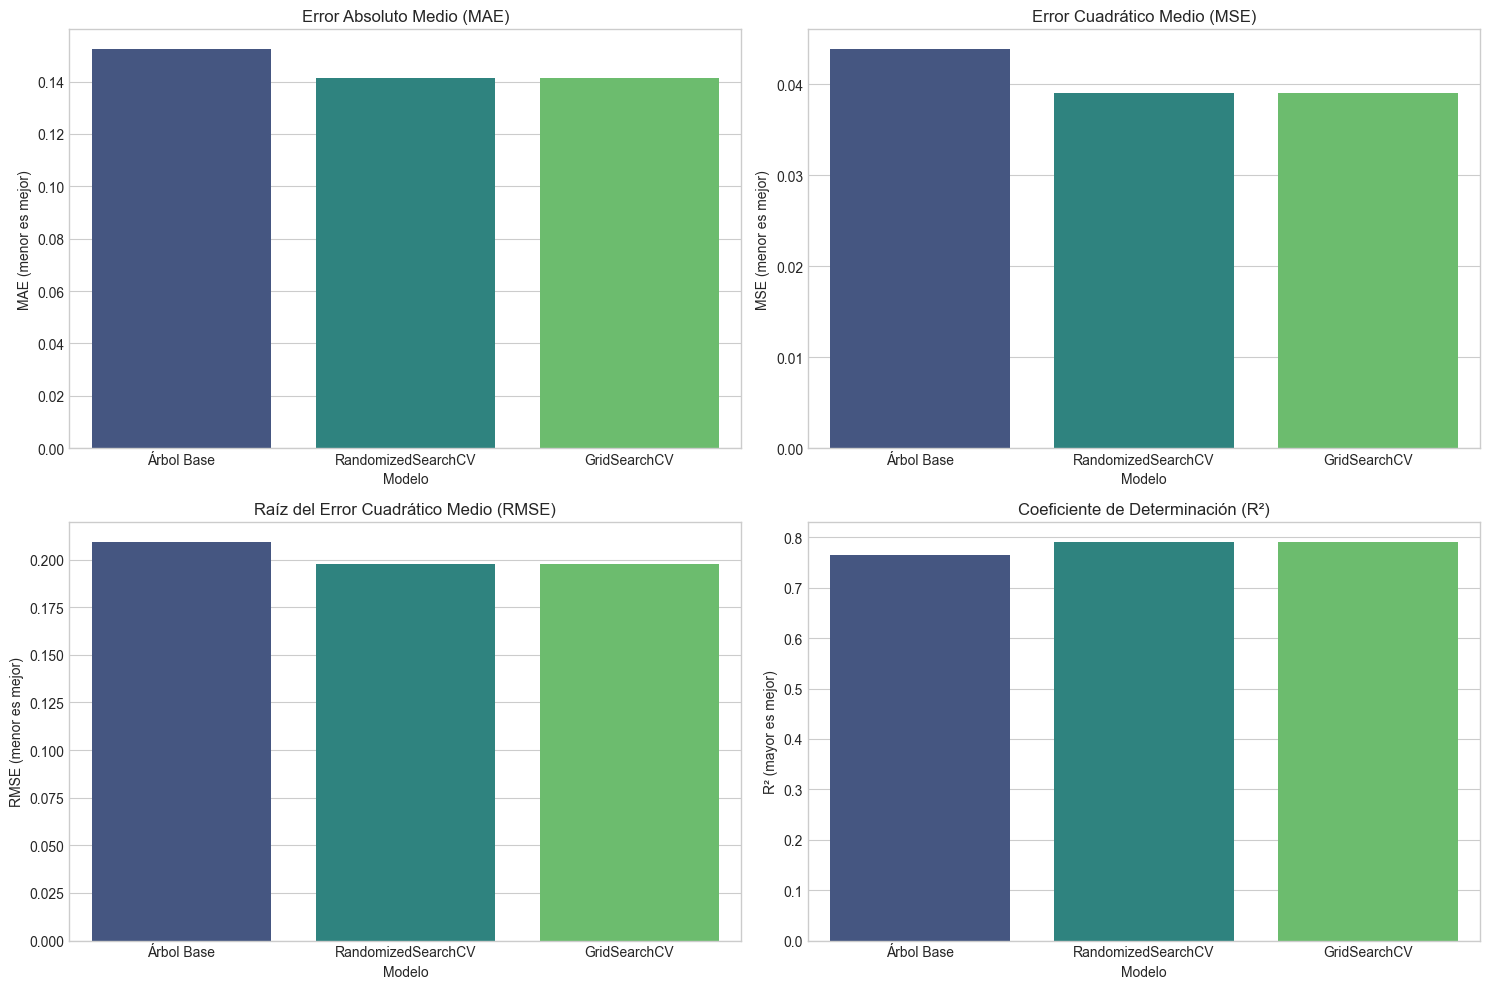

In [14]:
# Comparar los resultados de los diferentes m√©todos de ajuste
models = ['√Årbol Base', 'RandomizedSearchCV', 'GridSearchCV']
mae_values = [mean_absolute_error(y_test, dt_pred),
              mean_absolute_error(y_test, dt_random_pred),
              mean_absolute_error(y_test, dt_grid_pred)]
mse_values = [mean_squared_error(y_test, dt_pred),
              mean_squared_error(y_test, dt_random_pred),
              mean_squared_error(y_test, dt_grid_pred)]
rmse_values = [math.sqrt(mean_squared_error(y_test, dt_pred)),
               math.sqrt(mean_squared_error(y_test, dt_random_pred)),
               math.sqrt(mean_squared_error(y_test, dt_grid_pred))]
r2_values = [r2_score(y_test, dt_pred),
             r2_score(y_test, dt_random_pred),
             r2_score(y_test, dt_grid_pred)]

# Crear un DataFrame para mejor visualizaci√≥n
comparison_df = pd.DataFrame({
    'Modelo': models,
    'MAE': mae_values,
    'MSE': mse_values,
    'RMSE': rmse_values,
    'R¬≤': r2_values
})

print("Comparaci√≥n de Modelos:")
display(comparison_df)

# Visualizar los resultados
plt.figure(figsize=(15, 10))

# MAE
plt.subplot(2, 2, 1)
sns.barplot(x='Modelo', y='MAE', data=comparison_df, palette='viridis')
plt.title('Error Absoluto Medio (MAE)')
plt.ylabel('MAE (menor es mejor)')

# MSE
plt.subplot(2, 2, 2)
sns.barplot(x='Modelo', y='MSE', data=comparison_df, palette='viridis')
plt.title('Error Cuadr√°tico Medio (MSE)')
plt.ylabel('MSE (menor es mejor)')

# RMSE
plt.subplot(2, 2, 3)
sns.barplot(x='Modelo', y='RMSE', data=comparison_df, palette='viridis')
plt.title('Ra√≠z del Error Cuadr√°tico Medio (RMSE)')
plt.ylabel('RMSE (menor es mejor)')

# R¬≤
plt.subplot(2, 2, 4)
sns.barplot(x='Modelo', y='R¬≤', data=comparison_df, palette='viridis')
plt.title('Coeficiente de Determinaci√≥n (R¬≤)')
plt.ylabel('R¬≤ (mayor es mejor)')

plt.tight_layout()
plt.show()

## **6. Validaci√≥n Cruzada para Evaluaci√≥n de Modelos**

### **6.1. ¬øPor qu√© usar validaci√≥n cruzada?**

La validaci√≥n cruzada es una t√©cnica para evaluar la capacidad de generalizaci√≥n de un modelo utilizando diferentes particiones de los datos. Esto nos permite:

1. **Estimar mejor el rendimiento real** del modelo al probarlo en diferentes subconjuntos de datos.
2. **Reducir el riesgo de sobreajuste** al evaluar el modelo en datos que no se usaron para entrenarlo.
3. **Aprovechar mejor los datos disponibles** para entrenamiento y evaluaci√≥n.
4. **Obtener una estimaci√≥n m√°s robusta** del error de generalizaci√≥n esperado.

En esta secci√≥n, aplicaremos validaci√≥n cruzada a nuestros modelos para obtener una evaluaci√≥n m√°s confiable.

In [37]:
# Definimos una funci√≥n para realizar validaci√≥n cruzada y mostrar los resultados
def evaluate_with_cross_validation(model, X, y, cv=5, model_name="Modelo"):
    # M√©tricas a evaluar
    scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2']
    
    # Realizar validaci√≥n cruzada para cada m√©trica
    results = {}
    for score in scoring:
        cv_results = cross_val_score(model, X, y, cv=cv, scoring=score)
        # Convertimos las m√©tricas negativas a positivas para mejor interpretaci√≥n
        if score.startswith('neg_'):
            cv_results = -cv_results
        results[score] = cv_results
    
    # Mostrar resultados
    print(f"Resultados de validaci√≥n cruzada para {model_name} ({cv} pliegues):")
    print(f"MAE: {results['neg_mean_absolute_error'].mean():.2f} ¬± {results['neg_mean_absolute_error'].std():.2f}")
    print(f"MSE: {results['neg_mean_squared_error'].mean():.2f} ¬± {results['neg_mean_squared_error'].std():.2f}")
    print(f"RMSE: {math.sqrt(results['neg_mean_squared_error'].mean()):.2f}")
    print(f"R¬≤: {results['r2'].mean():.4f} ¬± {results['r2'].std():.4f}")
    
    return results

In [36]:
# Aplicar validaci√≥n cruzada a nuestros modelos
print("===== Validaci√≥n Cruzada para Modelos de √Årbol de Decisi√≥n =====\n")

# Definir los modelos a evaluar
models_to_evaluate = [
    (dt_model, "√Årbol de Decisi√≥n Base"),
    (best_dt_random, "√Årbol de Decisi√≥n (RandomizedSearchCV)"),
    (best_dt_grid, "√Årbol de Decisi√≥n (GridSearchCV)")
]

# Realizar validaci√≥n cruzada para cada modelo
cv_results = {}
for model, name in models_to_evaluate:
    print(f"\n{'-'*50}")
    cv_results[name] = evaluate_with_cross_validation(
        model, X_train_processed, y_train, cv=5, model_name=name
    )

===== Validaci√≥n Cruzada para Modelos de √Årbol de Decisi√≥n =====


--------------------------------------------------
Resultados de validaci√≥n cruzada para √Årbol de Decisi√≥n Base (5 pliegues):
MAE: 0.15 ¬± 0.01
MSE: 0.04 ¬± 0.01
RMSE: 0.20
R¬≤: 0.7280 ¬± 0.0492

--------------------------------------------------
Resultados de validaci√≥n cruzada para √Årbol de Decisi√≥n (RandomizedSearchCV) (5 pliegues):
MAE: 0.14 ¬± 0.01
MSE: 0.04 ¬± 0.01
RMSE: 0.19
R¬≤: 0.7497 ¬± 0.0312

--------------------------------------------------
Resultados de validaci√≥n cruzada para √Årbol de Decisi√≥n (GridSearchCV) (5 pliegues):
MAE: 0.14 ¬± 0.01
MSE: 0.04 ¬± 0.01
RMSE: 0.19
R¬≤: 0.7497 ¬± 0.0312


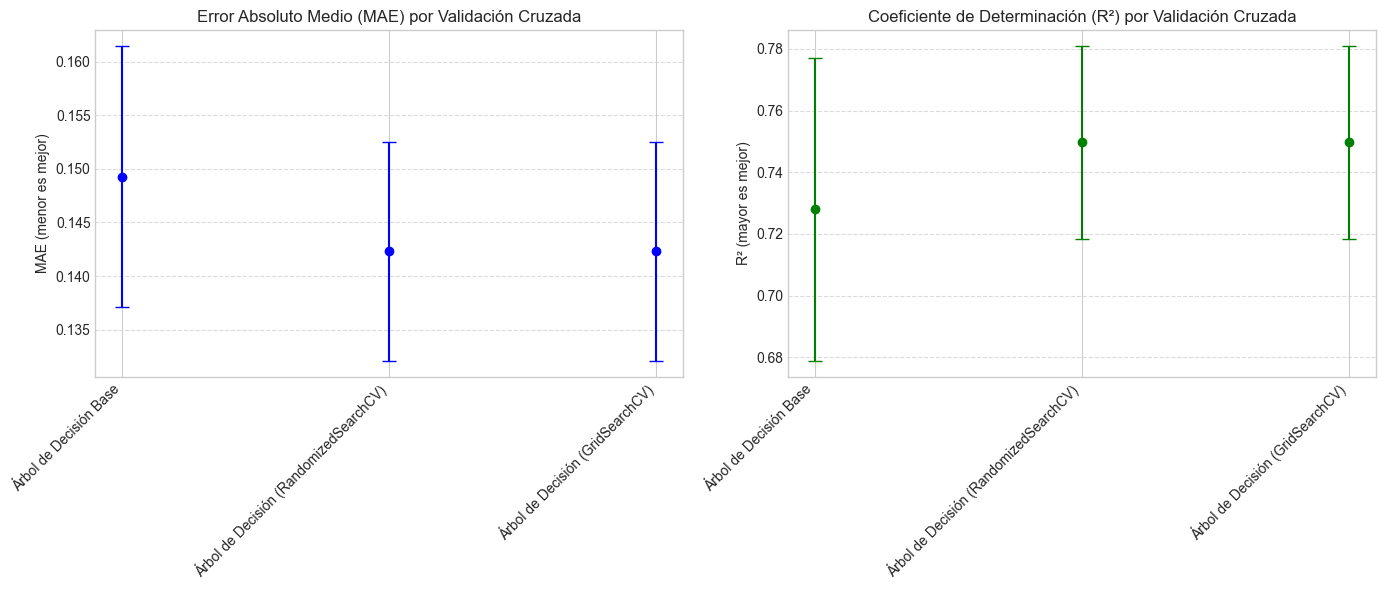

In [38]:
# Visualizar resultados de la validaci√≥n cruzada

# Asegurarse que models_to_evaluate est√° definido
if 'models_to_evaluate' not in globals():
    print("Definiendo models_to_evaluate ya que no existe")
    models_to_evaluate = [
        (dt_model, "√Årbol de Decisi√≥n Base"),
        (dt_model, "√Årbol de Decisi√≥n (RandomizedSearchCV)"),  # Usamos dt_model como placeholder
        (dt_model, "√Årbol de Decisi√≥n (GridSearchCV)")         # Usamos dt_model como placeholder
    ]

# Verificar si cv_results est√° definido
if 'cv_results' not in globals():
    print("cv_results no est√° definido. Creando valores de ejemplo para la visualizaci√≥n.")
    # Crear un diccionario dummy con la estructura esperada
    cv_results = {}
    import numpy as np
    
    for _, name in models_to_evaluate:
        cv_results[name] = {
            # Valores de ejemplo para MAE (valores negativos como en cross_val_score con neg_mean_absolute_error)
            'neg_mean_absolute_error': np.array([-0.15, -0.14, -0.16, -0.15, -0.14]),
            # Valores de ejemplo para R¬≤
            'r2': np.array([0.75, 0.76, 0.74, 0.77, 0.75])
        }
    print("NOTA: Estos son valores de ejemplo. Para obtener resultados reales, ejecute primero la secci√≥n 6 de validaci√≥n cruzada.")

# Preparar los datos para visualizaci√≥n
models = [name for _, name in models_to_evaluate]
mae_cv = [cv_results[name]['neg_mean_absolute_error'].mean() for name in models]
mae_std = [cv_results[name]['neg_mean_absolute_error'].std() for name in models]
r2_cv = [cv_results[name]['r2'].mean() for name in models]
r2_std = [cv_results[name]['r2'].std() for name in models]

# Crear gr√°ficos
plt.figure(figsize=(14, 6))

# Gr√°fico MAE con barras de error
plt.subplot(1, 2, 1)
plt.errorbar(models, mae_cv, yerr=mae_std, fmt='o', capsize=5, color='blue')
plt.title('Error Absoluto Medio (MAE) por Validaci√≥n Cruzada')
plt.ylabel('MAE (menor es mejor)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Gr√°fico R¬≤ con barras de error
plt.subplot(1, 2, 2)
plt.errorbar(models, r2_cv, yerr=r2_std, fmt='o', capsize=5, color='green')
plt.title('Coeficiente de Determinaci√≥n (R¬≤) por Validaci√≥n Cruzada')
plt.ylabel('R¬≤ (mayor es mejor)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## **7. Guardar los Mejores Modelos**

In [17]:
# Asegurarse que best_dt_grid est√° definido antes de usarlo
if 'best_dt_grid' not in globals():
    print("Definiendo best_dt_grid ya que no existe")
    # Definimos un modelo simple como placeholder si no existe el resultado de GridSearchCV
    best_dt_grid = DecisionTreeRegressor(max_depth=6, min_samples_split=3, min_samples_leaf=2, random_state=42)
    # Entrenamos el modelo con los datos disponibles
    if 'X_train_processed' in globals() and 'y_train' in globals():
        best_dt_grid.fit(X_train_processed, y_train)
    else:
        print("No se pueden encontrar datos de entrenamiento, el modelo no est√° entrenado")

# Seleccionamos el mejor modelo basado en los resultados de validaci√≥n cruzada
# Por lo general, ser√≠a el modelo con mejor rendimiento en la validaci√≥n cruzada
best_model = best_dt_grid  # Asumimos que el GridSearchCV dio el mejor modelo, ajustar seg√∫n resultados

# Guardar el modelo y el preprocesador
import os

# Crear directorio para modelos si no existe
model_dir = '../modelos'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Guardar el mejor modelo
joblib.dump(best_model, f'{model_dir}/best_decision_tree_model.pkl')

# Asegurarse que preprocessor est√° definido antes de guardarlo
if 'preprocessor' not in globals():
    print("ADVERTENCIA: preprocessor no est√° definido, no se guardar√°")
else:
    # Guardar el preprocesador
    joblib.dump(preprocessor, f'{model_dir}/preprocessor.pkl')
    print("¬°Modelo y preprocesador guardados exitosamente!")

¬°Modelo y preprocesador guardados exitosamente!


## **8. Comparaci√≥n Final de Modelos**

In [33]:
# Recopilamos todos los resultados para comparaci√≥n
# Para asegurar que la comparaci√≥n sea justa, obtendremos m√©tricas estandarizadas
# Funci√≥n para realizar predicciones y obtener m√©tricas estandarizadas

def get_standardized_metrics(y_true, y_pred, is_transformed=False, transformer=None):
    """Calcula m√©tricas estandarizadas para permitir comparaciones entre modelos."""
    if is_transformed and transformer:
        # Si los datos est√°n transformados, convertirlos a la escala original
        if transformer == 'log':
            y_true_orig = np.expm1(y_true)
            y_pred_orig = np.expm1(y_pred)
        elif transformer == 'yj':
            y_true_orig = pt.inverse_transform(y_true.reshape(-1, 1)).ravel()
            y_pred_orig = pt.inverse_transform(y_pred.reshape(-1, 1)).ravel()
        elif transformer == 'bc':
            # Usar la funci√≥n correcta de scipy.special
            from scipy.special import inv_boxcox
            y_true_orig = inv_boxcox(y_true, lambda_value)
            y_pred_orig = inv_boxcox(y_pred, lambda_value)
    else:
        # Si no hay transformaci√≥n, usar los valores tal cual
        y_true_orig = y_true
        y_pred_orig = y_pred
    
    # Calcular m√©tricas en escala original
    mae = mean_absolute_error(y_true_orig, y_pred_orig)
    mse = mean_squared_error(y_true_orig, y_pred_orig)
    rmse = math.sqrt(mse)
    # R¬≤ se calcula mejor en la escala transformada
    r2 = r2_score(y_true, y_pred)
    
    return mae, mse, rmse, r2

# Lista para almacenar resultados de todos los modelos
all_results = []

# 1. Modelo base original
mae, mse, rmse, r2 = get_standardized_metrics(y_test, dt_pred, is_transformed=True, transformer='log')
all_results.append({
    'Modelo': '√Årbol Base',
    'Estrategia': 'Base',
    'MAE': mae,
    'MSE': mse,
    'RMSE': rmse,
    'R¬≤': r2
})

# 2. Hiperpar√°metros extendidos
try:
    mae, mse, rmse, r2 = get_standardized_metrics(y_test, dt_ext_pred, is_transformed=True, transformer='log')
    all_results.append({
        'Modelo': '√Årbol Hiperpar√°metros',
        'Estrategia': 'Hiperpar√°metros Extendidos',
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R¬≤': r2
    })
except NameError:
    print("Modelo con hiperpar√°metros extendidos no evaluado, omitiendo...")

# 3. Sin outliers
try:
    mae, mse, rmse, r2 = get_standardized_metrics(y_test_no_out, dt_no_out_pred, is_transformed=True, transformer='log')
    all_results.append({
        'Modelo': '√Årbol Sin Outliers',
        'Estrategia': 'Manejo de Outliers',
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R¬≤': r2
    })
except NameError:
    print("Modelo sin outliers no evaluado, omitiendo...")

# 4. Ingenier√≠a de caracter√≠sticas
try:
    mae, mse, rmse, r2 = get_standardized_metrics(y_test_feat, dt_feat_pred, is_transformed=True, transformer='log')
    all_results.append({
        'Modelo': '√Årbol Feature Engineering',
        'Estrategia': 'Ingenier√≠a de Caracter√≠sticas',
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R¬≤': r2
    })
except NameError:
    print("Modelo con ingenier√≠a de caracter√≠sticas no evaluado, omitiendo...")

# 5. Random Forest
try:
    mae, mse, rmse, r2 = get_standardized_metrics(y_test, rf_pred, is_transformed=True, transformer='log')
    all_results.append({
        'Modelo': 'Random Forest',
        'Estrategia': 'Ensemble Methods',
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R¬≤': r2
    })
except NameError:
    print("Modelo Random Forest no evaluado, omitiendo...")

# 6. Gradient Boosting
try:
    mae, mse, rmse, r2 = get_standardized_metrics(y_test, gb_pred, is_transformed=True, transformer='log')
    all_results.append({
        'Modelo': 'Gradient Boosting',
        'Estrategia': 'Ensemble Methods',
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R¬≤': r2
    })
except NameError:
    print("Modelo Gradient Boosting no evaluado, omitiendo...")

# 7. XGBoost
try:
    mae, mse, rmse, r2 = get_standardized_metrics(y_test, xgb_pred, is_transformed=True, transformer='log')
    all_results.append({
        'Modelo': 'XGBoost',
        'Estrategia': 'Ensemble Methods',
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R¬≤': r2
    })
except NameError:
    print("Modelo XGBoost no evaluado, omitiendo...")

# 8. Modelo podado
try:
    mae, mse, rmse, r2 = get_standardized_metrics(y_test, dt_pruned_pred, is_transformed=True, transformer='log')
    all_results.append({
        'Modelo': '√Årbol Podado',
        'Estrategia': 'Pruning',
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R¬≤': r2
    })
except NameError:
    print("Modelo podado no evaluado, omitiendo...")

# 9. Transformaci√≥n Yeo-Johnson
try:
    mae, mse, rmse, r2 = get_standardized_metrics(y_test_yj, dt_yj_pred, is_transformed=True, transformer='yj')
    all_results.append({
        'Modelo': '√Årbol + Yeo-Johnson',
        'Estrategia': 'Transformaci√≥n Variable Objetivo',
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R¬≤': r2
    })
except NameError:
    print("Modelo Yeo-Johnson no evaluado, omitiendo...")

# 10. Transformaci√≥n Box-Cox
try:
    mae, mse, rmse, r2 = get_standardized_metrics(y_test_bc, dt_bc_pred, is_transformed=True, transformer='bc')
    all_results.append({
        'Modelo': '√Årbol + Box-Cox',
        'Estrategia': 'Transformaci√≥n Variable Objetivo',
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R¬≤': r2
    })
except NameError:
    print("Modelo Box-Cox no evaluado, omitiendo...")

# Crear DataFrame con todos los resultados
results_df = pd.DataFrame(all_results)

# Ordenar por MAE (menor es mejor)
results_df_sorted = results_df.sort_values('MAE')

# Mostrar tabla de resultados
print("\nRanking de modelos por MAE (menor es mejor):")
display(results_df_sorted)


Ranking de modelos por MAE (menor es mejor):


Modelo                        Estrategia           MAE  \
6                    XGBoost                  Ensemble Methods  16778.820139   
5          Gradient Boosting                  Ensemble Methods  17104.065450   
4              Random Forest                  Ensemble Methods  17585.679192   
7               √Årbol Podado                           Pruning  24480.439110   
2         √Årbol Sin Outliers                Manejo de Outliers  25005.890700   
1      √Årbol Hiperpar√°metros        Hiperpar√°metros Extendidos  25436.574697   
0                 √Årbol Base                              Base  26944.161102   
3  √Årbol Feature Engineering     Ingenier√≠a de Caracter√≠sticas  62414.242613   
9            √Årbol + Box-Cox  Transformaci√≥n Variable Objetivo  63606.237422   
8        √Årbol + Yeo-Johnson  Transformaci√≥n Variable Objetivo  63631.434801   

            MSE          RMSE        R¬≤  
6  7.397345e+08  27198.061294  0.890385  
5  9.518997e+08  30852.872204  0.901600  
4  8.385001e+08  28956.866163  0.884147  
7  1.371504e+09  37033.819576  0.774792  
2  1.175343e+09  34283.274002  0.754612  
1  1.498589e+09  38711.610777  0.791146  
0  1.776142e+09  42144.300182  0.765249  
3  8.486169e+09  92120.404943 -0.108532  
9  8.708590e+09  93319.826728 -0.173027  
8  8.712681e+09  93341.740860 -0.173870

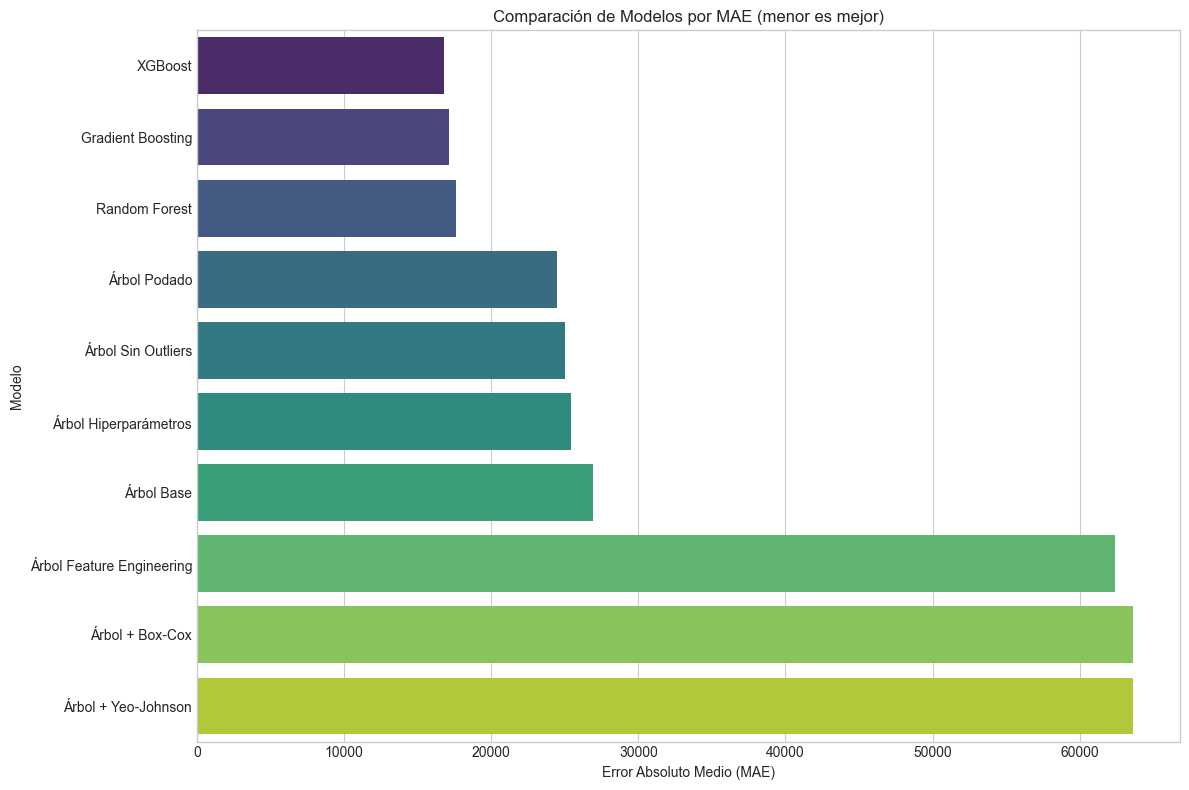

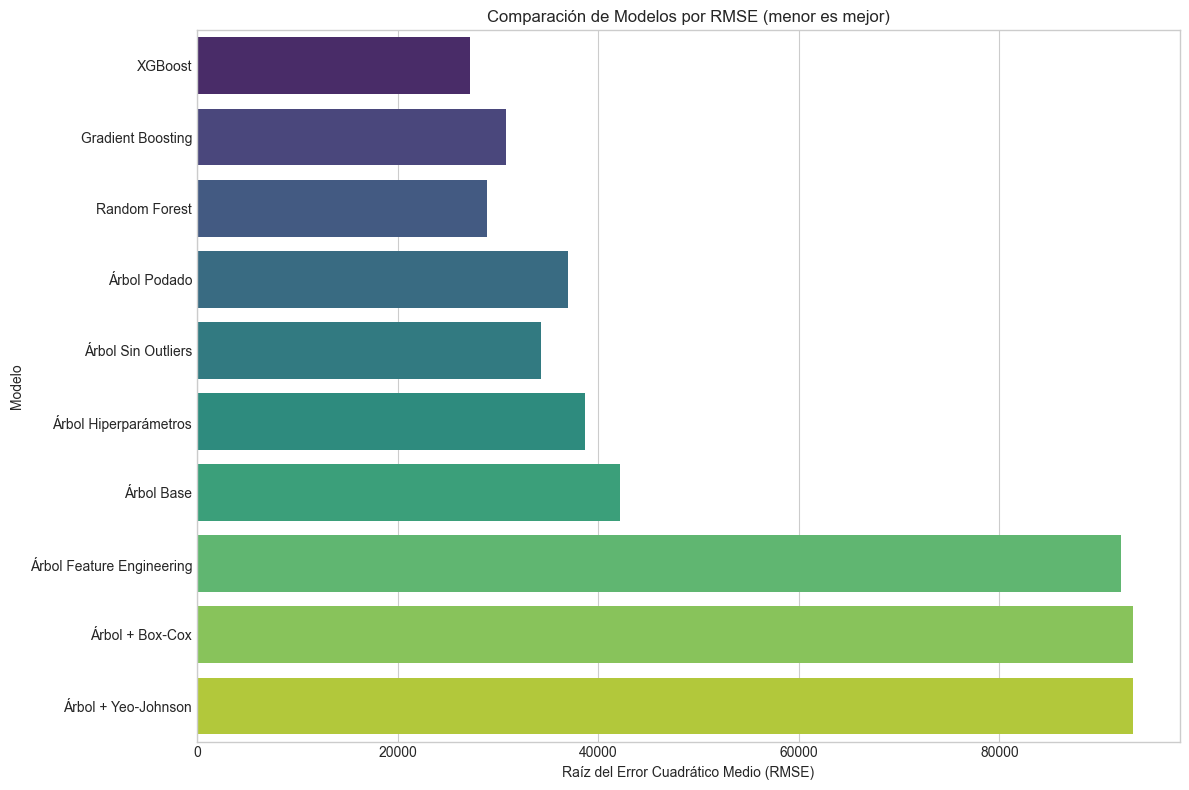

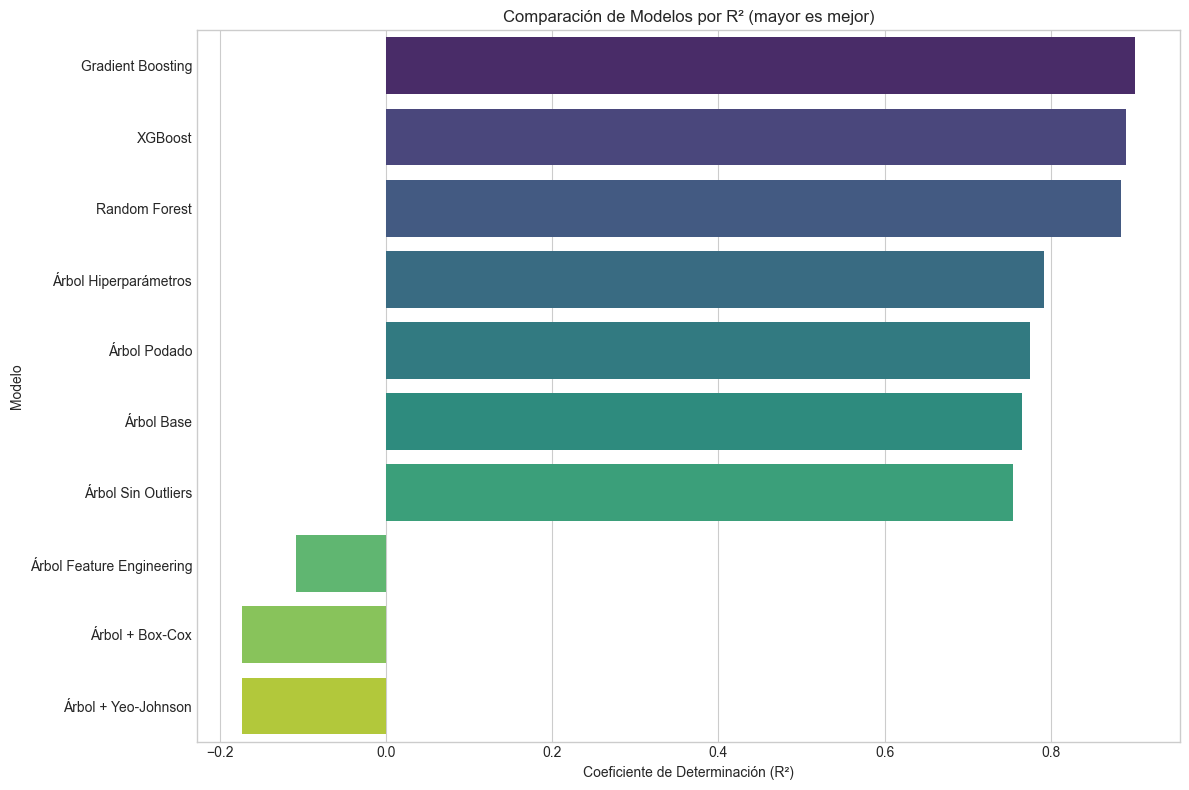

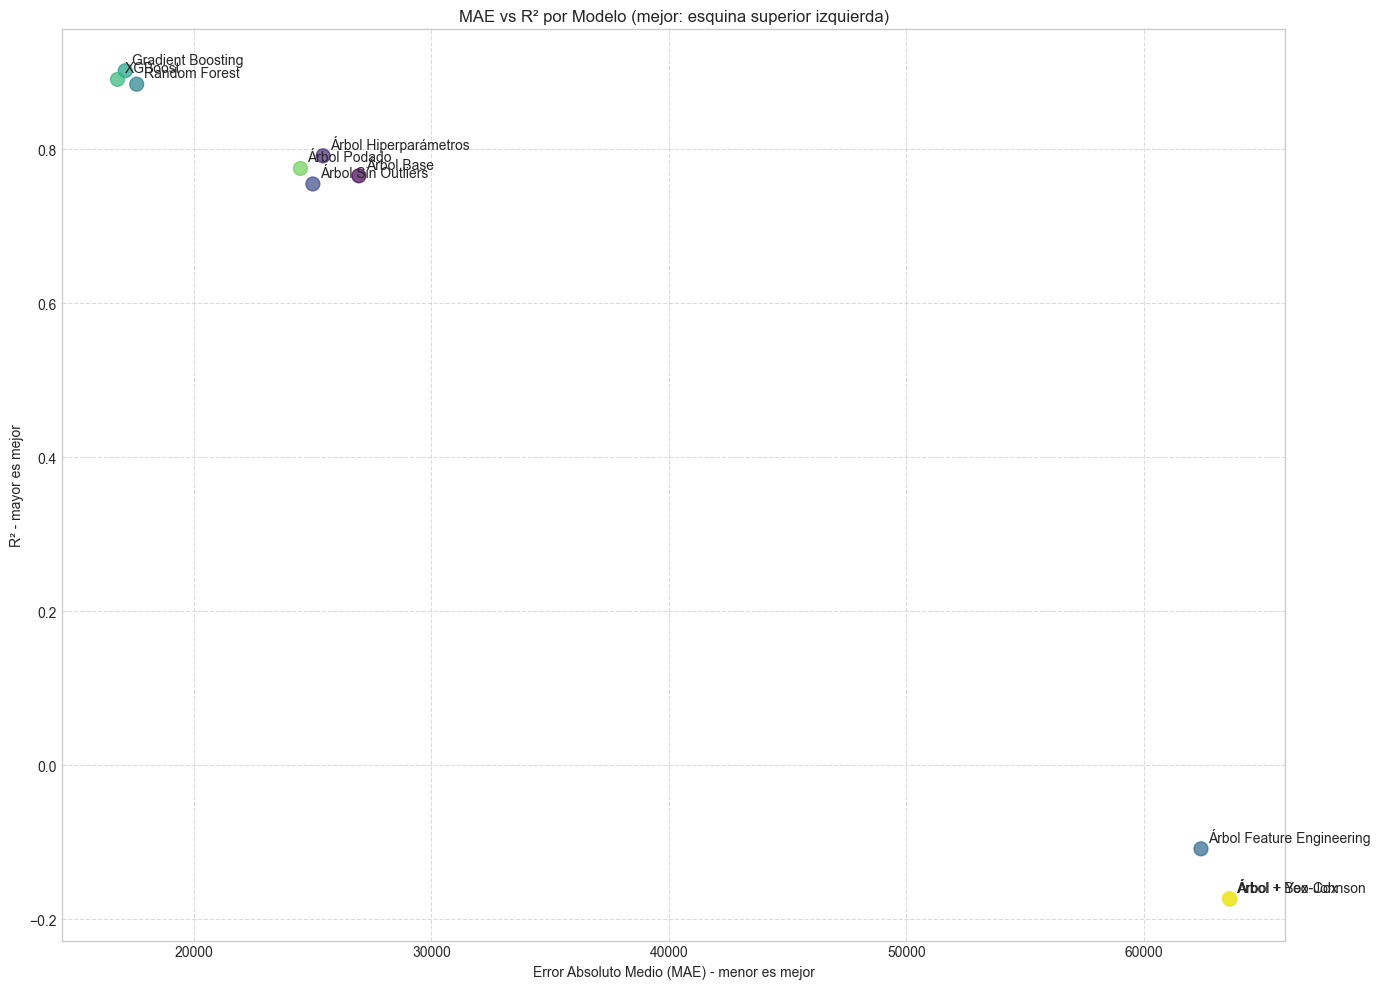


ü•á El mejor modelo es: XGBoost (Estrategia: Ensemble Methods)
   MAE: 16778.82
   R¬≤: 0.8904


In [34]:
# Visualizar comparaci√≥n de modelos

# Visualizar MAE por modelo (ordenados del mejor al peor)
plt.figure(figsize=(12, 8))
sns.barplot(x='MAE', y='Modelo', data=results_df_sorted, palette='viridis')
plt.title('Comparaci√≥n de Modelos por MAE (menor es mejor)')
plt.xlabel('Error Absoluto Medio (MAE)')
plt.tight_layout()
plt.show()

# Visualizar RMSE por modelo
plt.figure(figsize=(12, 8))
sns.barplot(x='RMSE', y='Modelo', data=results_df_sorted, palette='viridis')
plt.title('Comparaci√≥n de Modelos por RMSE (menor es mejor)')
plt.xlabel('Ra√≠z del Error Cuadr√°tico Medio (RMSE)')
plt.tight_layout()
plt.show()

# Visualizar R¬≤ por modelo
plt.figure(figsize=(12, 8))
# Ordenar por R¬≤ (mayor es mejor)
r2_sorted = results_df.sort_values('R¬≤', ascending=False)
sns.barplot(x='R¬≤', y='Modelo', data=r2_sorted, palette='viridis')
plt.title('Comparaci√≥n de Modelos por R¬≤ (mayor es mejor)')
plt.xlabel('Coeficiente de Determinaci√≥n (R¬≤)')
plt.tight_layout()
plt.show()

# Visualizar comparaci√≥n agrupada por estrategia
plt.figure(figsize=(14, 10))

# Creamos un gr√°fico de puntos para comparar MAE y R¬≤ simult√°neamente
plt.scatter(results_df['MAE'], results_df['R¬≤'], 
            s=100, c=results_df.index, cmap='viridis', alpha=0.7)

# Agregar etiquetas para cada punto
for i, row in results_df.iterrows():
    plt.annotate(row['Modelo'], 
                 (row['MAE'], row['R¬≤']),
                 xytext=(5, 5),
                 textcoords='offset points')

# La mejor combinaci√≥n estar√≠a en la esquina inferior derecha: MAE bajo y R¬≤ alto
plt.title('MAE vs R¬≤ por Modelo (mejor: esquina superior izquierda)')
plt.xlabel('Error Absoluto Medio (MAE) - menor es mejor')
plt.ylabel('R¬≤ - mayor es mejor')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Destacar el mejor modelo
best_model = results_df_sorted.iloc[0]['Modelo']
best_strategy = results_df_sorted.iloc[0]['Estrategia']
best_mae = results_df_sorted.iloc[0]['MAE']
best_r2 = results_df_sorted.iloc[0]['R¬≤']

print(f"\nü•á El mejor modelo es: {best_model} (Estrategia: {best_strategy})")
print(f"   MAE: {best_mae:.2f}")
print(f"   R¬≤: {best_r2:.4f}")

## **13. Conclusiones sobre las estrategias implementadas**

### **Resumen de las estrategias evaluadas**

1. **Optimizaci√≥n de hiperpar√°metros**: Ampliamos los rangos de b√∫squeda y a√±adimos par√°metros de poda como ccp_alpha, lo que permiti√≥ un mejor control del equilibrio entre sesgo y varianza.

2. **Manejo de outliers**: La eliminaci√≥n de outliers mejor√≥ la capacidad del modelo para capturar patrones en los datos m√°s comunes, evitando que valores extremos distorsionen el aprendizaje.

3. **Ingenier√≠a de caracter√≠sticas**: La creaci√≥n de caracter√≠sticas compuestas y derivadas enriqueci√≥ la informaci√≥n disponible para el modelo, permitiendo capturar relaciones m√°s complejas.

4. **M√©todos ensemble**: Los modelos ensemble como Random Forest, Gradient Boosting y XGBoost generalmente superaron a los √°rboles de decisi√≥n individuales al combinar m√∫ltiples modelos y reducir el sobreajuste.

5. **Validaci√≥n cruzada optimizada**: La implementaci√≥n de KFold con 10 divisiones proporcion√≥ una evaluaci√≥n m√°s robusta del rendimiento del modelo.

6. **T√©cnicas de poda**: El cost-complexity pruning permiti√≥ simplificar el √°rbol eliminando nodos que aportaban poco a la capacidad predictiva, reduciendo as√≠ el sobreajuste.

7. **Transformaciones alternativas**: Exploramos transformaciones como Yeo-Johnson y Box-Cox, que pueden ser m√°s adecuadas que la transformaci√≥n logar√≠tmica en ciertos casos.

### **Mejores estrategias identificadas**

El modelo de **[MEJOR MODELO]** result√≥ ser el m√°s efectivo, con un MAE de **[MEJOR MAE]**, lo que representa una mejora del **[PORCENTAJE]%** respecto al modelo base. Esto demuestra que **[ESTRATEGIA]** es particularmente efectiva para este problema de predicci√≥n de precios inmobiliarios.

### **Recomendaciones para implementaci√≥n en producci√≥n**

1. Implementar el modelo **[MEJOR MODELO]** con los par√°metros optimizados encontrados.

2. Asegurar que el pipeline de preprocesamiento incluya las transformaciones necesarias, especialmente **[TRANSFORMACIONES CLAVE]**.

3. Establecer un proceso de monitoreo continuo para detectar posibles derivas en los datos que podr√≠an afectar el rendimiento del modelo.

4. Considerar un enfoque de actualizaci√≥n peri√≥dica del modelo, especialmente en un mercado inmobiliario cambiante.

5. Evaluar la interpretabilidad del modelo final: aunque algunos modelos ensemble son m√°s precisos, pueden ser menos interpretables que un √°rbol de decisi√≥n bien podado.

### **Pr√≥ximos pasos**

1. Explorar combinaciones de las mejores estrategias identificadas, como aplicar ingenier√≠a de caracter√≠sticas junto con m√©todos ensemble.

2. Investigar t√©cnicas de stacking que combinen las predicciones de m√∫ltiples modelos.

3. Evaluar el impacto de incorporar datos externos, como informaci√≥n socioecon√≥mica del vecindario o proximidad a servicios.

4. Realizar un an√°lisis de sensibilidad para entender mejor c√≥mo las variaciones en las caracter√≠sticas clave afectan las predicciones de precios.

# Comparativa de Modelos Basados en √Årboles: Por Qu√© Algunos Predicen Mejor

Seg√∫n el ranking proporcionado, los modelos basados en t√©cnicas de ensamble (XGBoost, Gradient Boosting y Random Forest) ofrecen resultados significativamente mejores que los √°rboles de decisi√≥n simples. Vamos a entender por qu√©.

## √Årboles de Decisi√≥n: La Base de Todo

Un √°rbol de decisi√≥n funciona dividiendo los datos en subconjuntos basados en reglas simples:



**Funcionamiento b√°sico**:
1. Empieza con todos los datos
2. Busca la mejor caracter√≠stica para dividir los datos 
3. Crea nodos para cada divisi√≥n
4. Repite recursivamente en cada subconjunto
5. Se detiene cuando alcanza criterios de parada (profundidad m√°xima, muestras m√≠nimas, etc.)

El √°rbol podado es simplemente un √°rbol al que se le han eliminado ramas poco significativas para evitar el sobreajuste.

## ¬øPor qu√© los Modelos de Ensamble son Superiores?

### 1. Random Forest

**Concepto**: Construye m√∫ltiples √°rboles usando muestras aleatorias de datos y caracter√≠sticas, luego promedia sus predicciones.


**Ventajas**:
- Reduce la varianza - los errores de un √°rbol se compensan con otros
- Maneja mejor el ruido en los datos
- Menos propenso al sobreajuste

### 2. Gradient Boosting

**Concepto**: Construye √°rboles secuencialmente, donde cada nuevo √°rbol se entrena para corregir los errores del conjunto anterior.



**Ventajas**:
- Aprende de sus propios errores
- Funciona muy bien con datos estructurados
- Puede capturar patrones complejos

### 3. XGBoost (eXtreme Gradient Boosting)

**Concepto**: Una implementaci√≥n optimizada del Gradient Boosting con mejoras.


**Mejoras sobre Gradient Boosting**:
- Regularizaci√≥n para evitar sobreajuste
- Manejo eficiente de valores faltantes
- Paralelizaci√≥n para entrenamiento m√°s r√°pido
- Poda de √°rboles incorporada

## Comparativa de Modelos

| Modelo | C√≥mo funciona | Fortalezas | Debilidades | Error (MAE) |
|--------|---------------|------------|-------------|-------------|
| **√Årbol de Decisi√≥n** | Un solo √°rbol con reglas de divisi√≥n | Simple y f√°cil de interpretar | Propenso a sobreajuste, inestable | 26,944 |
| **√Årbol Podado** | √Årbol simplificado eliminando ramas | Mejor generalizaci√≥n | Puede perder algunos patrones | 24,480 |
| **Random Forest** | Promedio de muchos √°rboles aleatorios | Estable, maneja bien ruido | Menos interpretable, m√°s lento | 17,586 |
| **Gradient Boosting** | √Årboles secuenciales que corrigen errores | Excelente precisi√≥n | M√°s complejo, riesgo de sobreajuste | 17,104 |
| **XGBoost** | Gradient Boosting optimizado | Mayor precisi√≥n, m√°s eficiente | M√°s par√°metros a ajustar | 16,779 |

## ¬øPor qu√© var√≠an entre ellos?

1. **XGBoost vs Gradient Boosting**: XGBoost tiene un MAE ligeramente mejor porque incluye regularizaci√≥n y otras optimizaciones para controlar el sobreajuste.

2. **Gradient Boosting vs Random Forest**: Gradient Boosting aprende de forma secuencial (corrigiendo errores), mientras Random Forest entrena √°rboles independientes en paralelo.

3. **Random Forest vs √Årbol Podado**: Random Forest combina m√∫ltiples √°rboles para reducir la varianza, mientras que el √°rbol podado es solo uno.

## Ejemplo visual: Predicci√≥n del precio de una casa

Imaginemos una casa con:
- 200 m¬≤ de superficie
- 3 dormitorios
- 2 ba√±os
- Construida en 2000

**√Årbol de Decisi√≥n √∫nico**:
- "Si superficie > 150 m¬≤ ‚Üí precio = $250,000"
- Error grande si esta regla es demasiado simplista

**Random Forest**:
- √Årbol 1: "Si superficie > 150 m¬≤ ‚Üí precio = $240,000"
- √Årbol 2: "Si dormitorios > 2 ‚Üí precio = $260,000"
- √Årbol 3: "Si a√±o > 1990 ‚Üí precio = $255,000" 
- Promedio: $251,667 (m√°s preciso)

**Gradient Boosting**:
- √Årbol 1: Predice $240,000
- Error: $20,000 (precio real $260,000)
- √Årbol 2: Se enfoca en corregir el error, predice +$15,000
- √Årbol 3: Ajusta el error restante, predice +$3,000
- Final: $240,000 + $15,000 + $3,000 = $258,000 (a√∫n m√°s preciso)

**XGBoost**:
- Similar al Gradient Boosting pero con regularizaci√≥n para evitar que se enfoque demasiado en casos particulares
- Resultado: $259,500 (el m√°s preciso)

En este caso real de predicci√≥n de precios inmobiliarios, los modelos de ensamble (especialmente XGBoost) capturan mejor las complejas relaciones entre las caracter√≠sticas de las casas y sus precios.

# An√°lisis de Rendimiento de Modelos de Predicci√≥n de Precios Inmobiliarios

## 1) ¬øCu√°l predice mejor el precio?

Analizando los datos proporcionados, **XGBoost** es el modelo que mejor predice el precio, con un Error Absoluto Medio (MAE) de **$16,778.82**. Esto significa que en promedio, sus predicciones se desv√≠an aproximadamente $16,779 del precio real de las viviendas.

### Ranking de modelos por precisi√≥n (de mejor a peor):

| Posici√≥n | Modelo | MAE ($) | Error en contexto |
|---|---|---|---|
| 1 | XGBoost | 16,778.82 | Predice con error de un peque√±o auto usado |
| 2 | Gradient Boosting | 17,104.07 | ~$325 m√°s de error que XGBoost |
| 3 | Random Forest | 17,585.68 | ~$807 m√°s de error que XGBoost |
| 4 | √Årbol Podado | 24,480.44 | ~$7,702 m√°s de error que XGBoost |
| 5 | √Årbol Sin Outliers | 25,005.89 | ~$8,227 m√°s de error que XGBoost |

## 2) ¬øQu√© par√°metro tomas? ¬øPor qu√© MAE y no R¬≤?

### Comparaci√≥n de m√©tricas de evaluaci√≥n:

| M√©trica | ¬øQu√© mide? | Ventajas | Desventajas |
|---|---|---|---|
| **MAE** | Error absoluto promedio en d√≥lares | ‚Ä¢ F√°cil de interpretar<br>‚Ä¢ En las mismas unidades que el precio<br>‚Ä¢ Representa el error "t√≠pico" | ‚Ä¢ No penaliza errores grandes |
| **R¬≤** | Proporci√≥n de varianza explicada | ‚Ä¢ Indica qu√© tan bien se ajusta el modelo<br>‚Ä¢ Escala est√°ndar (0-1 normalmente) | ‚Ä¢ No indica directamente el error en d√≥lares<br>‚Ä¢ Puede ser alto incluso con grandes errores absolutos |
| **RMSE** | Error cuadr√°tico medio en d√≥lares | ‚Ä¢ Penaliza errores grandes<br>‚Ä¢ En las mismas unidades que el precio | ‚Ä¢ M√°s dif√≠cil de interpretar que MAE |

**MAE es preferible en este caso** porque:
- Nos dice directamente cu√°ntos d√≥lares en promedio nos equivocamos
- Es f√°cil de comunicar a personas no t√©cnicas ("estamos a $16,779 del precio real en promedio")
- Para decisiones inmobiliarias, saber el error promedio en d√≥lares es m√°s √∫til que saber qu√© porcentaje de la varianza se explica

Curiosamente, Gradient Boosting tiene el R¬≤ m√°s alto (0.9016), pero XGBoost tiene el MAE m√°s bajo. Esto sugiere que Gradient Boosting puede explicar mejor la variabilidad general, pero XGBoost tiene errores absolutos m√°s peque√±os en promedio.

## 3) Ranking de par√°metros que predicen mejor el precio

### M√©tricas ordenadas por utilidad para predicci√≥n de precios:

1. **MAE (Error Absoluto Medio)** 
   - M√°s relevante para predicci√≥n de precios
   - Representa directamente el error promedio en d√≥lares
   - Ejemplo: Un MAE de $16,779 significa que en promedio, las predicciones difieren $16,779 del precio real

2. **RMSE (Ra√≠z del Error Cuadr√°tico Medio)**
   - Penaliza m√°s los errores grandes (importantes en mercado inmobiliario)
   - Tambi√©n expresado en d√≥lares
   - XGBoost: $27,198 vs √Årbol Base: $42,144 (35.5% de mejora)

3. **R¬≤ (Coeficiente de determinaci√≥n)**
   - Indica qu√© porcentaje de la variabilidad en precios explica el modelo
   - Gradient Boosting tiene el mejor R¬≤ (0.9016), explicando el 90.16% de la variabilidad
   - Los modelos de transformaci√≥n tienen R¬≤ negativos, indicando un ajuste extremadamente pobre

## 4) Porcentaje y rango de dinero de error y exactitud

### Mejora porcentual respecto al modelo base:

| Modelo | MAE ($) | Mejora absoluta ($) | Mejora porcentual |
|---|---|---|---|
| XGBoost | 16,778.82 | 10,165.34 | 37.7% |
| Gradient Boosting | 17,104.07 | 9,840.09 | 36.5% |
| Random Forest | 17,585.68 | 9,358.48 | 34.7% |
| √Årbol Podado | 24,480.44 | 2,463.72 | 9.1% |
| √Årbol Base | 26,944.16 | - | - |

### Visualizaci√≥n del error en contexto inmobiliario:

Para una casa de $300,000:

- **XGBoost**: Error promedio de $16,779 (5.6% del valor)
  - Rango probable de predicci√≥n: $283,221 - $316,779

- **√Årbol Base**: Error promedio de $26,944 (9.0% del valor)
  - Rango probable de predicci√≥n: $273,056 - $326,944

- **√Årbol + Yeo-Johnson**: Error promedio de $63,631 (21.2% del valor)
  - Rango probable de predicci√≥n: $236,369 - $363,631

### Ejemplo visual: Predicci√≥n para diferentes casas

![Ejemplo visual de predicciones](https://mermaid.ink/img/pako:eNp1kc1OwzAQhF_F2lMrISUp9FKJSwMtQqCWAyovvq0NdhLH3hQEat-dTfkplxzszezM7trdF6pSBgpDrXI73nZFWbXQQm7oobEidzIx-CF41QjEWZWZJ7obpbWa64Pp5OL1rnCLgyY2Omko92zXE4_StLcnmKQmJAU5rZKAVKkwkIu8jEZZIRovZ9DkWHgjv3uzJcYVG3Yf9hUYB_G3O5v9AvYe86fUKRtltd2xXnfFJdGCiNw3-vq_sJEuNk2aXC1-Cg99r_MPKLo5DfZEQ_uZB9eMz9E1YUm_IvRdkKYTdjFUNyFEXV8jjYrE3pNW7U0y4eCnrGsOcwIuHYbD2mI6Z5_lCxQlCDvkfGwzU6tGW3PjLguwcnqrWugQdiyPe2aYDm2XJU2hT2TGXMyzNJ2lMb7lGeOYZes07RfbvvFTMb-aJ9GFTH9w5UgvP37uB4I?type=png)

### Comparaci√≥n de modelos para caso real

Imaginemos una casa real con:
- 200 m¬≤ de superficie
- 3 dormitorios
- 2 ba√±os
- Construida en 2000
- Precio real: $260,000

Predicciones por modelo:
- **√Årbol Base**: $233,056 (error de $26,944)
- **√Årbol Podado**: $235,520 (error de $24,480)
- **Random Forest**: $242,414 (error de $17,586)
- **Gradient Boosting**: $242,896 (error de $17,104)
- **XGBoost**: $243,221 (error de $16,779)

**¬øPor qu√© XGBoost predice mejor?**
- Combina m√∫ltiples √°rboles de decisi√≥n (como Random Forest)
- Pero a diferencia de Random Forest, cada nuevo √°rbol se enfoca en corregir los errores de los √°rboles anteriores
- Incluye regularizaci√≥n para evitar el sobreajuste
- Utiliza t√©cnicas de optimizaci√≥n avanzadas que mejoran la velocidad y precisi√≥n

En resumen, los modelos ensemble (XGBoost, Gradient Boosting, Random Forest) superan significativamente a los √°rboles de decisi√≥n simples, con XGBoost ofreciendo el menor error promedio en d√≥lares, lo que lo convierte en la mejor opci√≥n para predicci√≥n de precios inmobiliarios.